## Importing Libraries

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import log_loss,accuracy_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
import scipy
from sklearn.naive_bayes import MultinomialNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from mlxtend.classifier import StackingClassifier
from sklearn.ensemble import VotingClassifier

## Reading Data

In [2]:
data1=pd.read_csv("../Data/training_variants",header=0)

In [3]:
print(data1.head())

   ID    Gene             Variation  Class
0   0  FAM58A  Truncating Mutations      1
1   1     CBL                 W802*      2
2   2     CBL                 Q249E      2
3   3     CBL                 N454D      3
4   4     CBL                 L399V      4


In [4]:
print("No of data Points",data1.shape[0])
print("No of data Features",data1.shape[1])
print("Features",data1.columns.values)

No of data Points 3321
No of data Features 4
Features ['ID' 'Gene' 'Variation' 'Class']


In [5]:
data2=pd.read_csv("../Data/training_text",sep="\|\|",engine='python',names=["ID","TEXT"],skiprows=1)

In [6]:
print(data2.head())

   ID                                               TEXT
0   0  Cyclin-dependent kinases (CDKs) regulate a var...
1   1   Abstract Background  Non-small cell lung canc...
2   2   Abstract Background  Non-small cell lung canc...
3   3  Recent evidence has demonstrated that acquired...
4   4  Oncogenic mutations in the monomeric Casitas B...


In [7]:
print(data1['Class'].value_counts())

7    953
4    686
1    568
2    452
6    275
5    242
3     89
9     37
8     19
Name: Class, dtype: int64


## Preprocessing Text Feild

In [8]:
nltk.download('stopwords')
stop_words=set(stopwords.words('english'))
def preprocess_data(text,index,column):
    #replacing special sybols with empty
    text=re.sub('[^a-zA-Z0-9\n\s\-]','',text)
    #more than one space with single space
    text=re.sub("\s\s+"," ",text)
    #converting text to lower case 
    text=text.lower()
    t=""
    #removing stopwords
    for word in text.split():
        if word not in stop_words:
            t += word + " "
    data2[column][index]=t

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kanis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
for index, row in data2.iterrows():
    if type(row['TEXT']) is str:
        preprocess_data(row['TEXT'], index, 'TEXT')
    else:
        print("there is no text description for id:",index)

C:\Users\kanis\AppData\Local\Temp\ipykernel_18724\1870034692.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2[column][index]=t


there is no text description for id: 1109
there is no text description for id: 1277
there is no text description for id: 1407
there is no text description for id: 1639
there is no text description for id: 2755


In [10]:
print(data2.head())

   ID                                               TEXT
0   0  cyclin-dependent kinases cdks regulate variety...
1   1  abstract background non-small cell lung cancer...
2   2  abstract background non-small cell lung cancer...
3   3  recent evidence demonstrated acquired uniparen...
4   4  oncogenic mutations monomeric casitas b-lineag...


## Merging on Id

In [11]:
data=pd.merge(data1,data2,on='ID')

In [12]:
print(data.head())

   ID    Gene             Variation  Class  \
0   0  FAM58A  Truncating Mutations      1   
1   1     CBL                 W802*      2   
2   2     CBL                 Q249E      2   
3   3     CBL                 N454D      3   
4   4     CBL                 L399V      4   

                                                TEXT  
0  cyclin-dependent kinases cdks regulate variety...  
1  abstract background non-small cell lung cancer...  
2  abstract background non-small cell lung cancer...  
3  recent evidence demonstrated acquired uniparen...  
4  oncogenic mutations monomeric casitas b-lineag...  


## Checking for null values

In [13]:
print(data[data.isnull().any(axis=1)])

        ID    Gene             Variation  Class TEXT
1109  1109   FANCA                S1088F      1  NaN
1277  1277  ARID5B  Truncating Mutations      1  NaN
1407  1407   FGFR3                 K508M      6  NaN
1639  1639    FLT1         Amplification      6  NaN
2755  2755    BRAF                 G596C      7  NaN


Replacing Nan value in text with gene+" "+variation

In [14]:
data.loc[data['TEXT'].isnull(),'TEXT'] = data['Gene'] +' '+data['Variation']

In [15]:
print(data[data['ID']==1109])

        ID   Gene Variation  Class          TEXT
1109  1109  FANCA    S1088F      1  FANCA S1088F


# Spliting data into Train,Test,CV

In [16]:
y=data['Class'].values

In [17]:
data.Gene      = data.Gene.str.replace('\s+', '_')
data.Variation = data.Variation.str.replace('\s+', '_')

C:\Users\kanis\AppData\Local\Temp\ipykernel_18724\70849633.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  data.Gene      = data.Gene.str.replace('\s+', '_')
C:\Users\kanis\AppData\Local\Temp\ipykernel_18724\70849633.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  data.Variation = data.Variation.str.replace('\s+', '_')


In [18]:
X_train,X_test,y_train,y_test=train_test_split(data,y,test_size=0.2)

In [19]:
X_train,X_cv,y_train,y_cv=train_test_split(X_train,y_train,test_size=0.2)

# Checking points in each class of train,test and cv data

In [20]:
print("Training Data")
print(X_train.shape)
print("Testing Data")
print(X_test.shape)
print("CV Data")
print(X_cv.shape)

Training Data
(2124, 5)
Testing Data
(665, 5)
CV Data
(532, 5)


No. of datapoint in class 1: 373
No. of datapoint in class 2: 264
No. of datapoint in class 3: 49
No. of datapoint in class 4: 451
No. of datapoint in class 5: 154
No. of datapoint in class 6: 178
No. of datapoint in class 7: 616
No. of datapoint in class 8: 9
No. of datapoint in class 9: 30


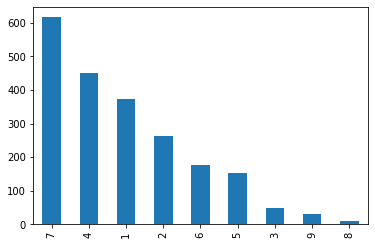

In [21]:
for i in range(1,10):
    print("No. of datapoint in class {}: {}".format(i,X_train['Class'][X_train['Class']==i].count()))
    
X_train['Class'].value_counts().plot(kind='bar')
plt.show()

No. of datapoint in class 1: 110
No. of datapoint in class 2: 117
No. of datapoint in class 3: 27
No. of datapoint in class 4: 119
No. of datapoint in class 5: 50
No. of datapoint in class 6: 56
No. of datapoint in class 7: 178
No. of datapoint in class 8: 4
No. of datapoint in class 9: 4


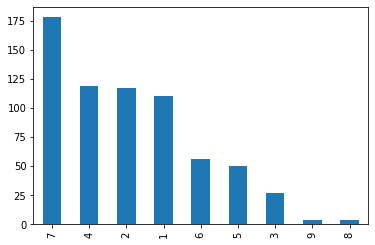

In [22]:
for i in range(1,10):
    print("No. of datapoint in class {}: {}".format(i,X_test['Class'][X_test['Class']==i].count()))
    
X_test['Class'].value_counts().plot(kind='bar')
plt.show()

No. of datapoint in class 1: 85
No. of datapoint in class 2: 71
No. of datapoint in class 3: 13
No. of datapoint in class 4: 116
No. of datapoint in class 5: 38
No. of datapoint in class 6: 41
No. of datapoint in class 7: 159
No. of datapoint in class 8: 6
No. of datapoint in class 9: 3


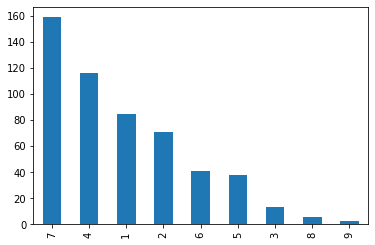

In [23]:
for i in range(1,10):
    print("No. of datapoint in class {}: {}".format(i,X_cv['Class'][X_cv['Class']==i].count()))
    
X_cv['Class'].value_counts().plot(kind='bar')
plt.show()

# Imabalanced Dataset

# Gene Feature Analysis

In [24]:
print("There are total {} unique genes".format(len(X_train["Gene"].unique())))

There are total 224 unique genes


In [25]:
unique_gene=X_train["Gene"].value_counts()

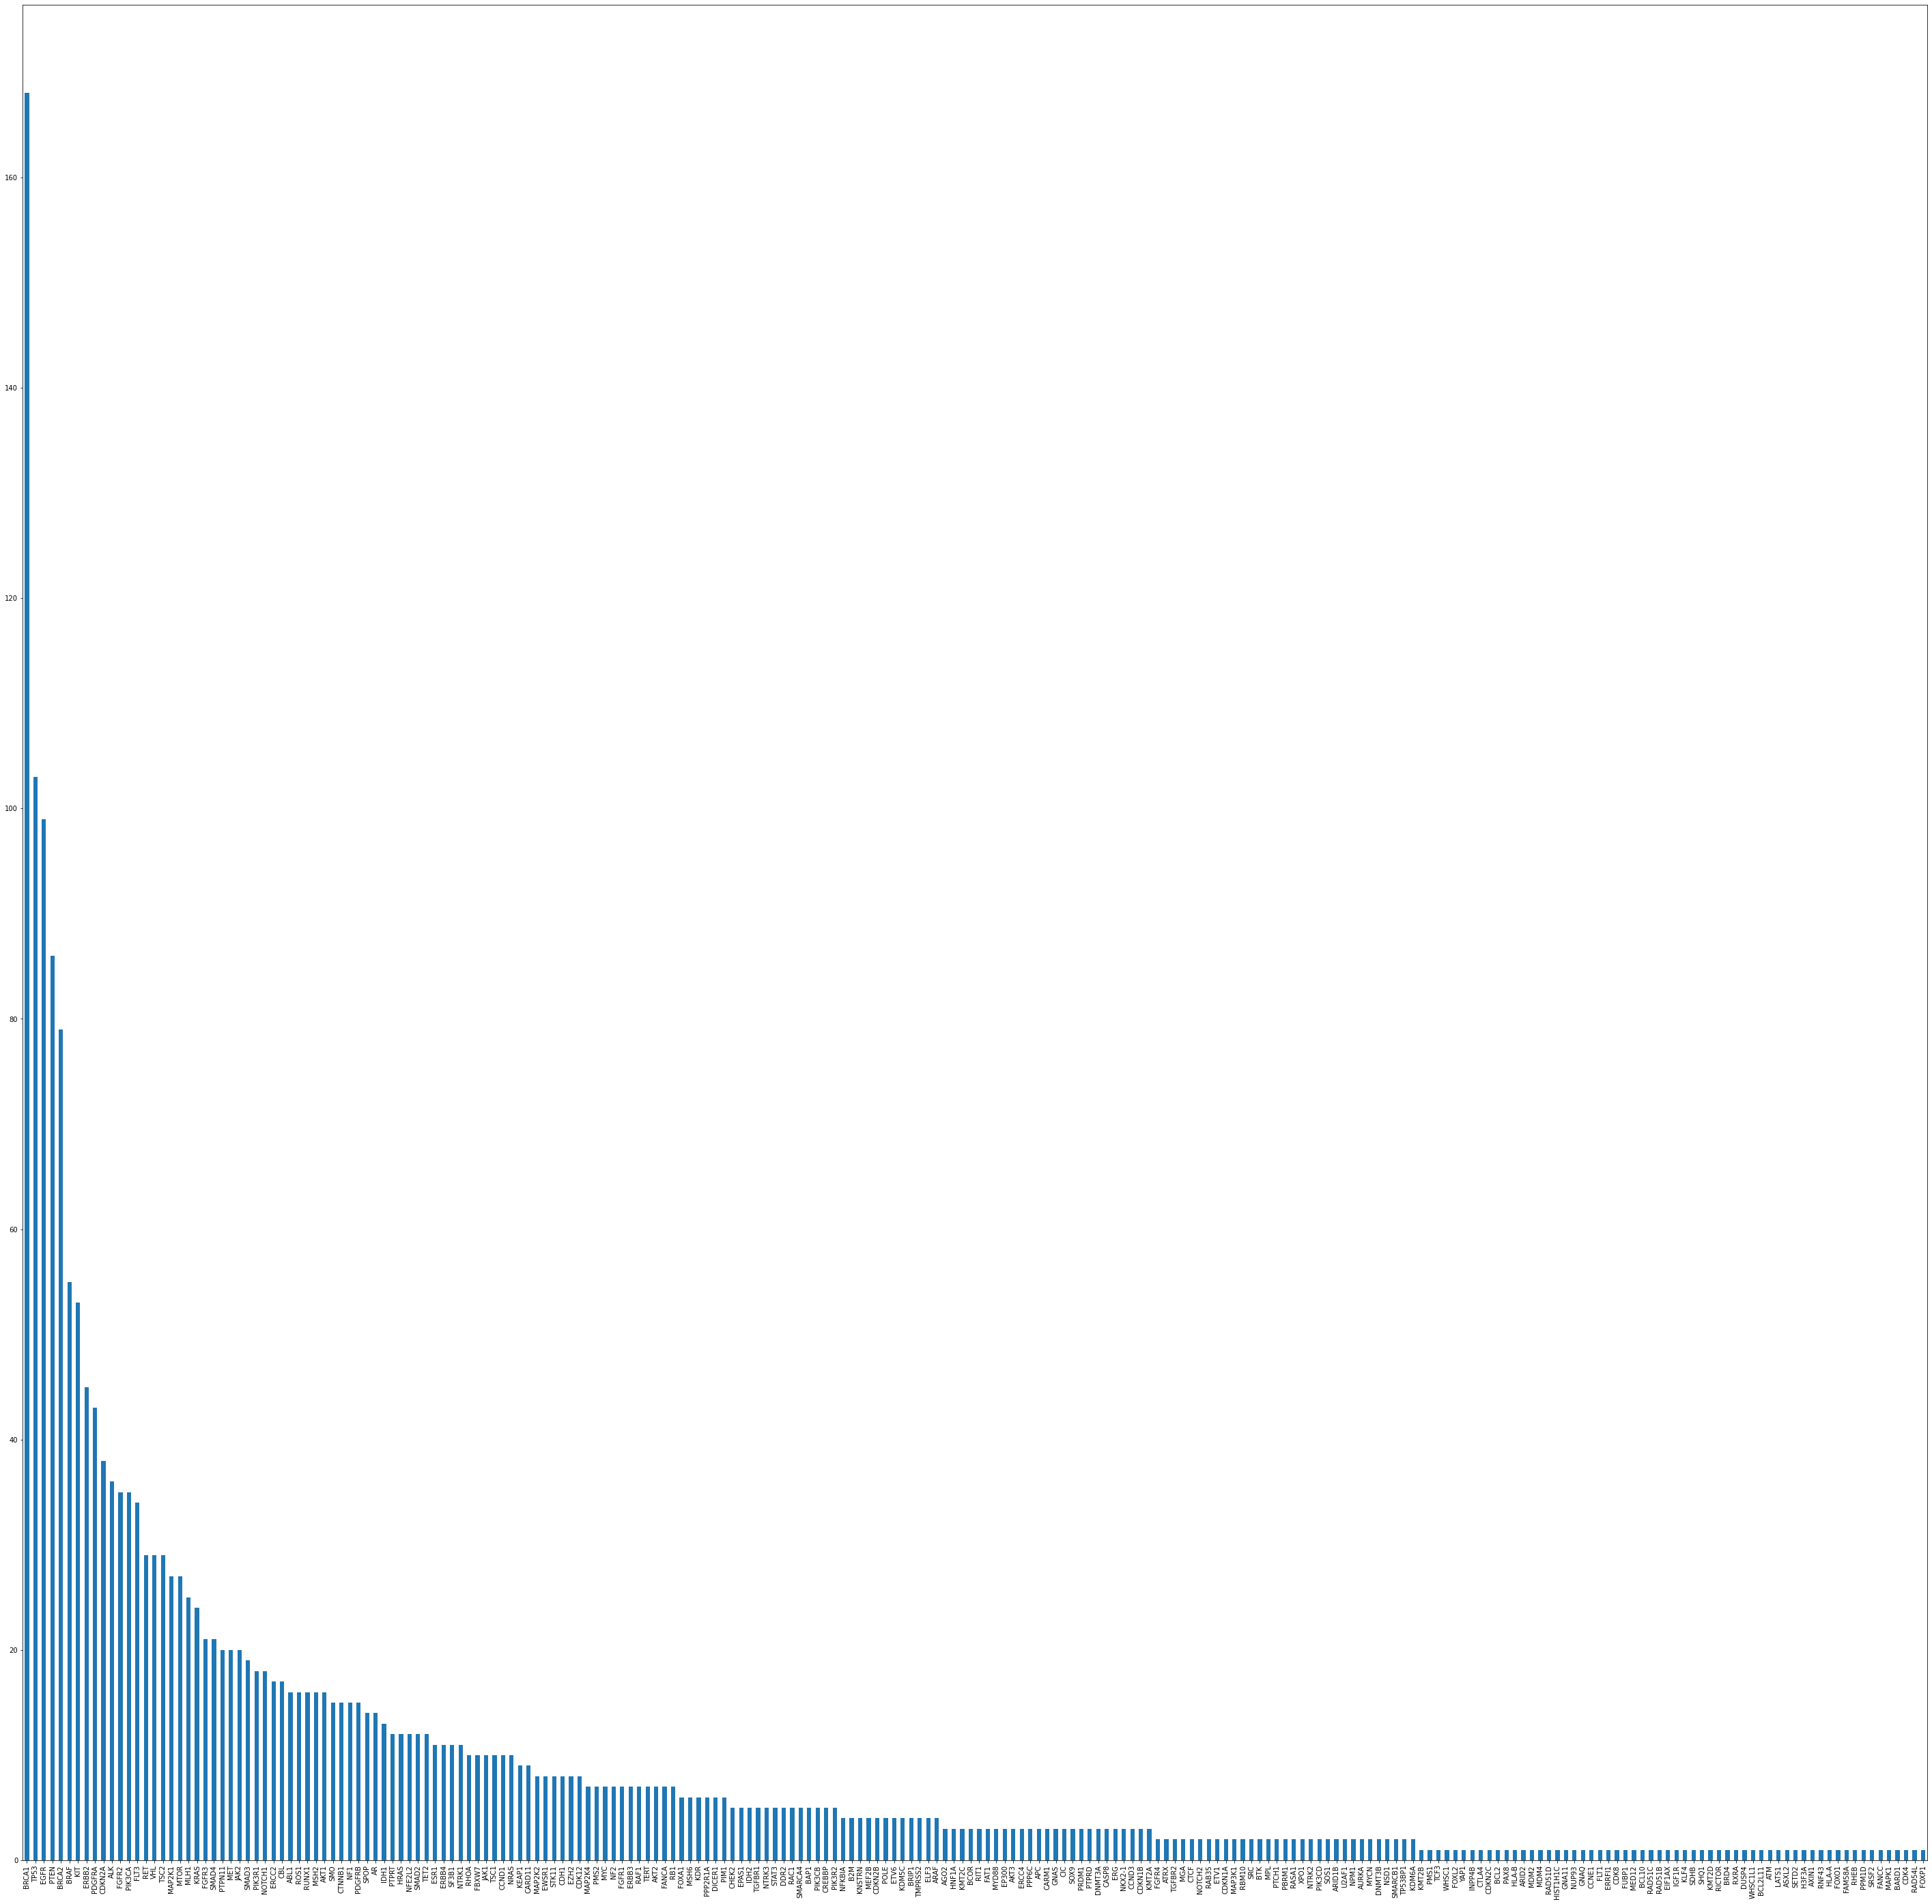

In [26]:
#Histogram 
unique_gene.plot(kind="bar",figsize=(50,50))
plt.show()

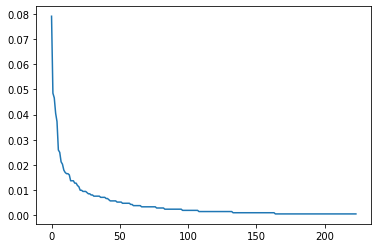

In [27]:
#PDF
s=np.sum(unique_gene)
h=unique_gene.values/s
plt.plot(h)
plt.show()

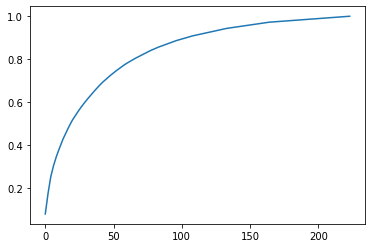

In [28]:
#CDF
c=np.cumsum(h)
plt.plot(c)
plt.show()

In [29]:
#To featureize Gene/Variation feature we will use response coding
def response_coding(feature,gen,df):
    unique_features=df[feature].value_counts()
    alpha=1
    f=dict()
    for i,d in unique_features.items():
        
        l=[]
        for p in range(1,10):
            res=df.loc[(df['Class']==p) & (df[feature]==i)]
            l.append((res.shape[0]+(alpha*10))/(d+(alpha*90)))
            
        f[i]=l
    final_feature=[]
    for index,row in gen.iterrows():
        if row[feature] in f:
            final_feature.append(f[row[feature]])
        else:
            final_feature.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
    return final_feature

In [30]:
gene_features_Train=np.array(response_coding("Gene",X_train,X_train))
gene_features_Test=np.array(response_coding("Gene",X_test,X_train))
gene_features_CV=np.array(response_coding("Gene",X_cv,X_train))

In [31]:
print("Train Gene feature shape is :",gene_features_Train.shape)

Train Gene feature shape is : (2124, 9)


In [32]:
gene_feature_vectorizer=CountVectorizer()
train_feature_gene_ohe=gene_feature_vectorizer.fit_transform(X_train['Gene'])
test_feature_gene_ohe=gene_feature_vectorizer.transform(X_test['Gene'])
cv_feature_gene_ohe=gene_feature_vectorizer.transform(X_cv['Gene'])

In [33]:
print(gene_feature_vectorizer.get_feature_names_out().shape)

(223,)


In [34]:
print(train_feature_gene_ohe.shape)
print(test_feature_gene_ohe.shape)
print(cv_feature_gene_ohe.shape)

(2124, 223)
(665, 223)
(532, 223)


In [35]:
#Overlap between gene feature in train,test and cv

set_train_gene=set(X_train["Gene"])
set_test_gene=set(X_test["Gene"])
set_cv_gene=set(X_cv["Gene"])

i=0
for j in set_test_gene:
    if j not in set_train_gene:
        i+=1
        
print((len(set_test_gene)-i)/len(set_test_gene) *100,"% Are genes in test that are in train")

i=0
for j in set_cv_gene:
    if j not in set_train_gene:
        i+=1
        
print((len(set_cv_gene)-i)/len(set_cv_gene) *100,"% Are genes in cv that are in train")

83.53658536585365 % Are genes in test that are in train
85.61151079136691 % Are genes in cv that are in train


# Variation Feature Ananlysis

Variation is categorical variable

In [36]:
unique_variation=X_train['Variation'].value_counts()
print("Total number of unique features in variation ",len(unique_variation))

Total number of unique features in variation  1944


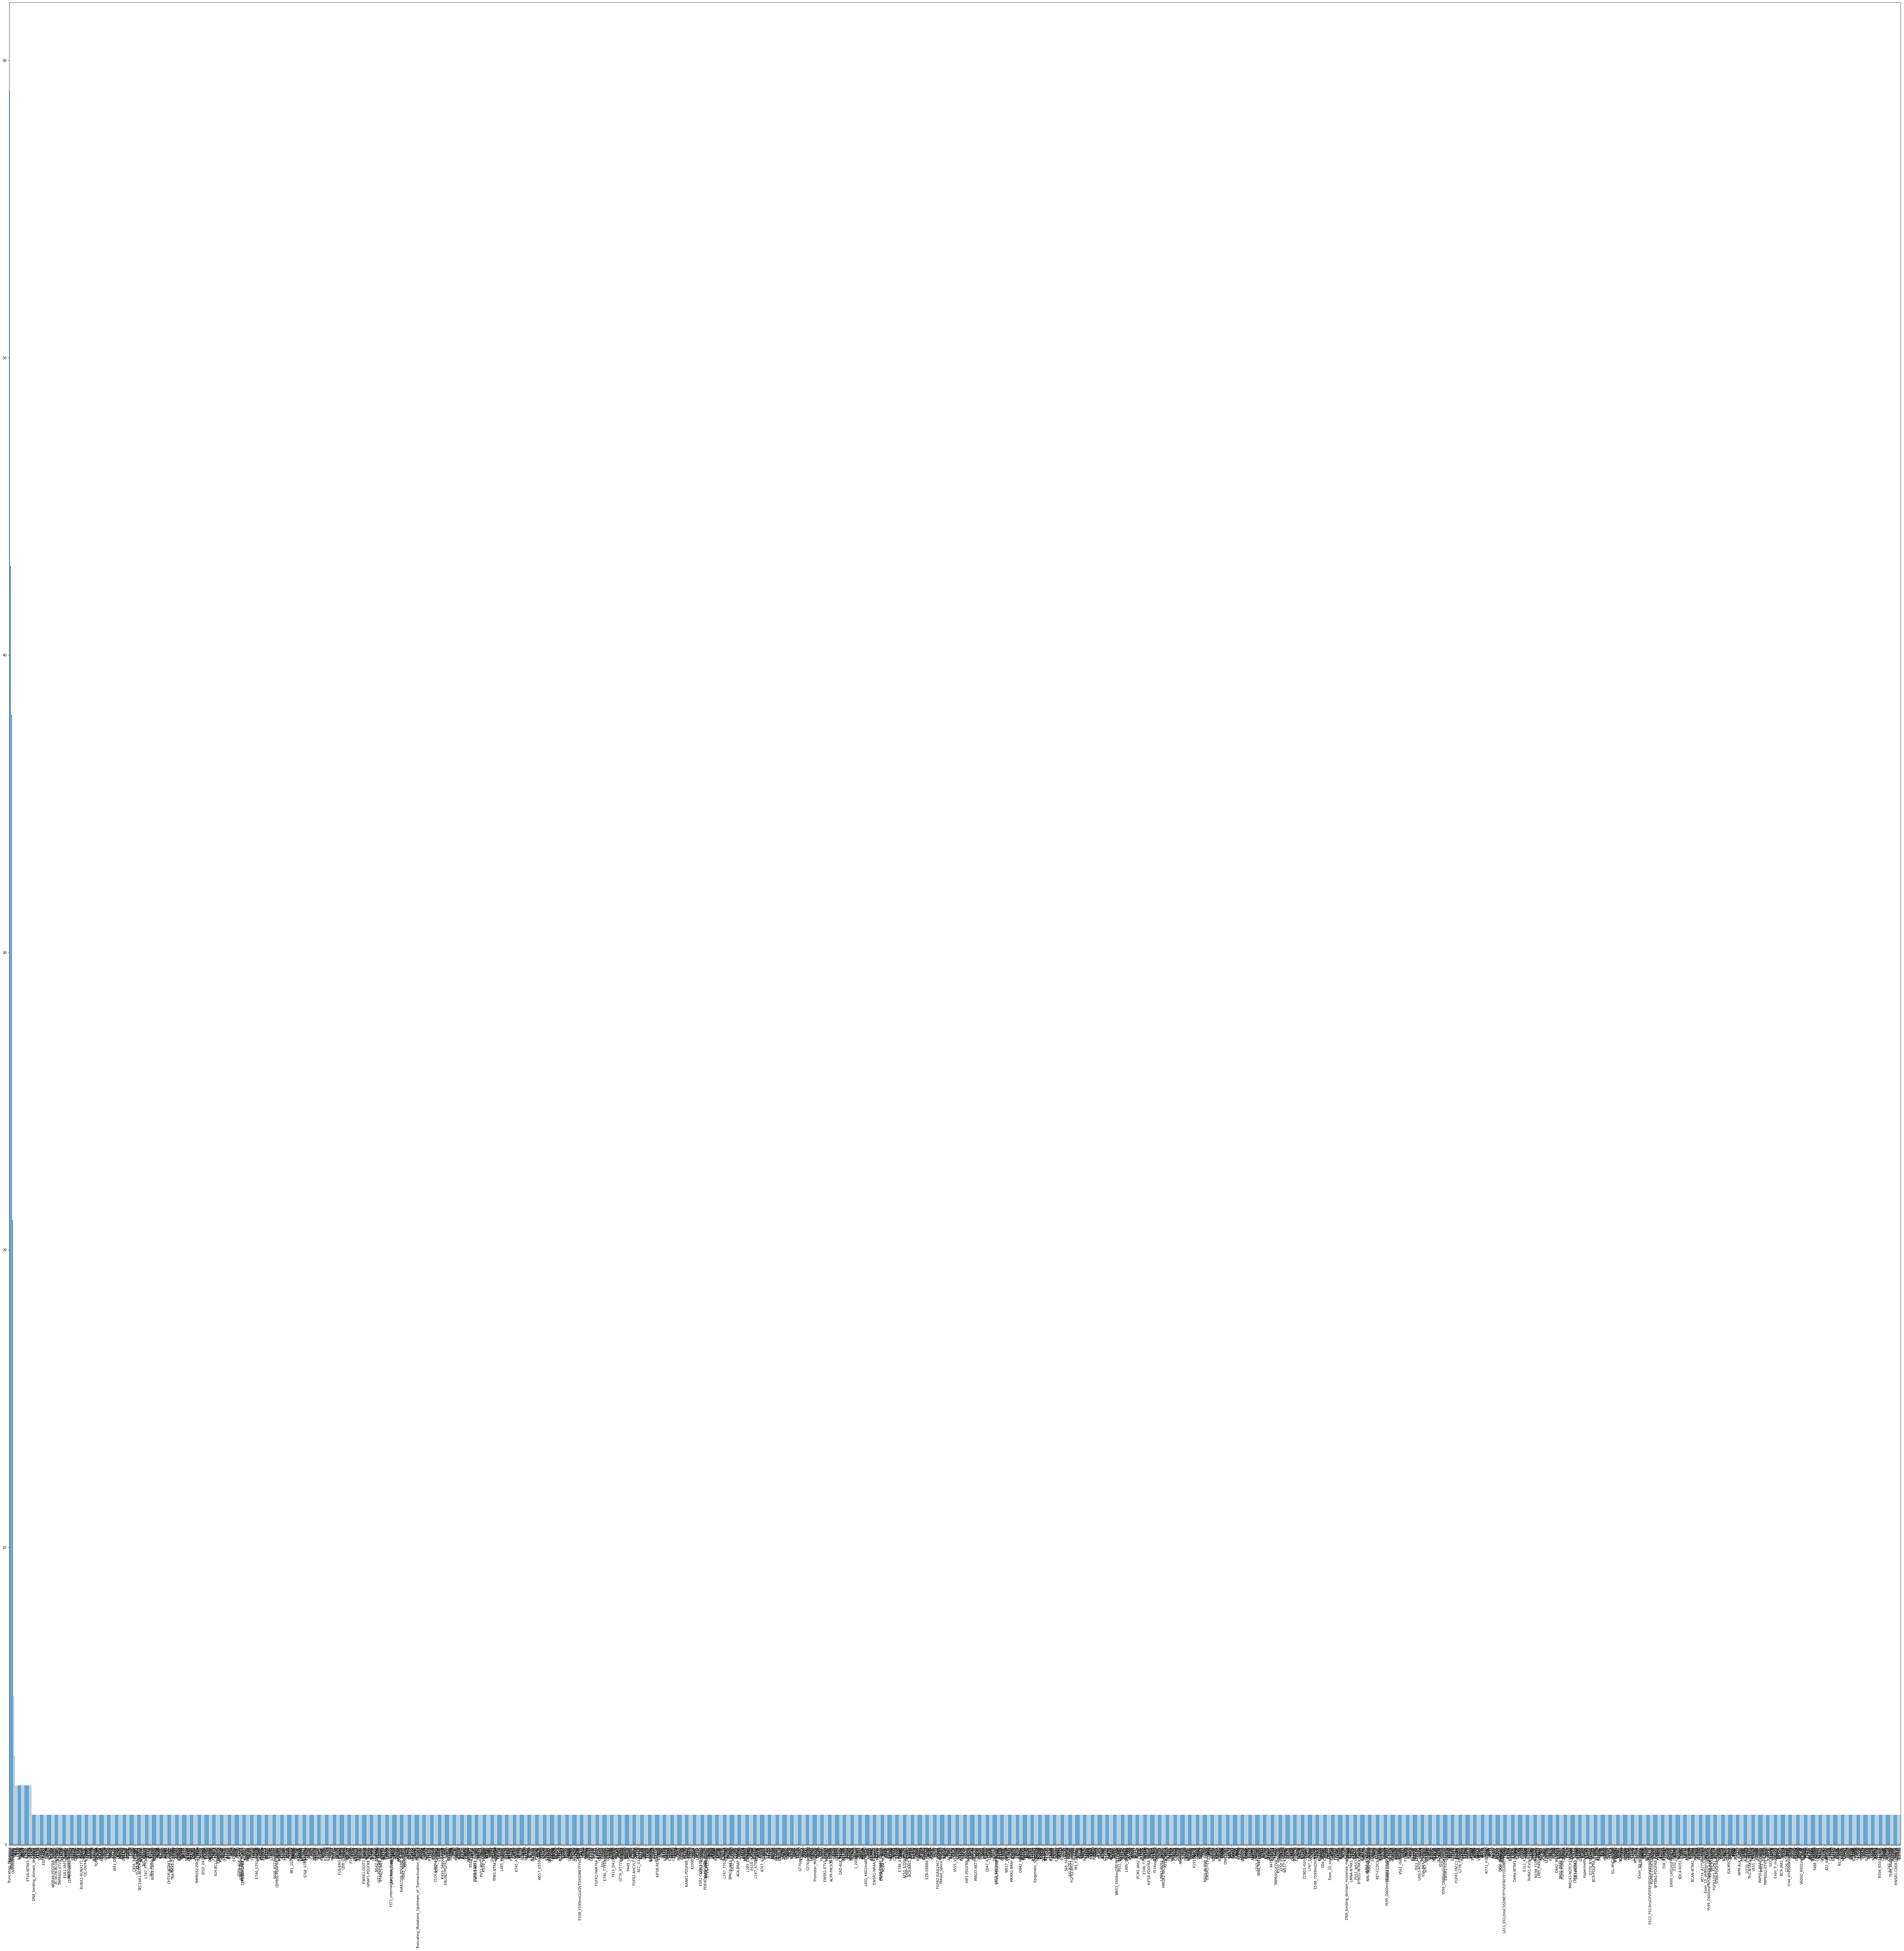

In [37]:
unique_variation.plot(kind='bar',figsize=(100,100))
plt.show()

In [38]:
print(unique_variation.head(15))

Truncating_Mutations    59
Deletion                43
Amplification           38
Fusions                 21
Overexpression           5
G12V                     3
G67R                     2
M1R                      2
G13D                     2
T73I                     2
R170W                    2
K117N                    2
Q209L                    2
Q61R                     2
Q61K                     2
Name: Variation, dtype: int64


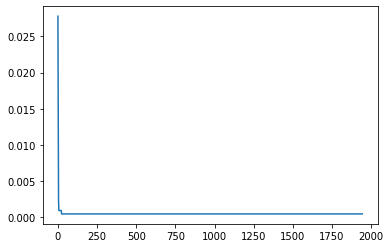

In [39]:
x=unique_variation.sum()
h=unique_variation.values/x
plt.plot(h)
plt.show()

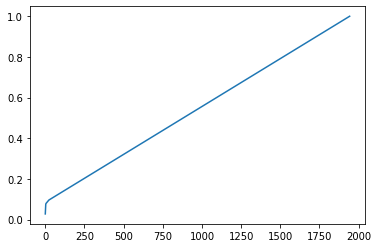

In [40]:
x=np.cumsum(unique_variation.values)
p=unique_variation.values.sum()
x=x/p
plt.plot(x)
plt.show()

In [41]:
variation_features_Train=np.array(response_coding("Variation",X_train,X_train))
variation_features_Test=np.array(response_coding("Variation",X_test,X_train))
variation_features_CV=np.array(response_coding("Variation",X_cv,X_train))

In [42]:
variation_feature_vectorizer=CountVectorizer()
train_feature_variation_ohe=variation_feature_vectorizer.fit_transform(X_train['Variation'])
test_feature_variation_ohe=variation_feature_vectorizer.transform(X_test['Variation'])
cv_feature_variation_ohe=variation_feature_vectorizer.transform(X_cv['Variation'])

In [43]:
variation_feature_vectorizer.get_feature_names_out().shape

(1976,)

In [44]:
print(train_feature_variation_ohe.shape)
print(test_feature_variation_ohe.shape)
print(cv_feature_variation_ohe.shape)

(2124, 1976)
(665, 1976)
(532, 1976)


In [45]:
#Overlap between gene feature in train,test and cv

set_train_variation=set(X_train["Variation"])
set_test_variation=set(X_test["Variation"])
set_cv_variation=set(X_cv["Variation"])

i=0
for j in set_test_variation:
    if j not in set_train_variation:
        i+=1
        
print(i/len(set_test_variation) *100,"% Are variation in test that are not in train")

i=0
for j in set_cv_variation:
    if j not in set_train_variation:
        i+=1
        
print((len(set_cv_variation)-i)/len(set_cv_variation) *100,"% Are variation in cv that are in train")

96.16026711185309 % Are variation in test that are not in train
2.8513238289205702 % Are variation in cv that are in train


Variation is not stable across test train and cv

# Text Feature

In [46]:
def response_dict_text(df):
    total_dict=dict()
    dict_class=dict()
    for index,row in df.iterrows():
        for word in row['TEXT'].split():
            t=(word,row['Class'])
            dict_class[t]=dict_class.get(t,0)+1
            
            total_dict[word]=total_dict.get(word,0)+1
    
    return total_dict,dict_class

In [47]:
import math

def get_text_responsecoding(df,data):
    text_feature_responseCoding = np.zeros((data.shape[0],9))
    total_dict,dict_text=response_dict_text(df)
    for i in range(1,10):
        row_index = 0
        for index, row in data.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_text.get((word,i),0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i-1] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [48]:
train_text_feature_responseCoding  = get_text_responsecoding(X_train,X_train)
test_text_feature_responseCoding  = get_text_responsecoding(X_train,X_test)
cv_text_feature_responseCoding  = get_text_responsecoding(X_train,X_cv)

In [49]:
#each row values sum to 1
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [50]:
text_vectorizer=CountVectorizer(min_df=3,ngram_range=(1,2))
train_feature_text_ohe=text_vectorizer.fit_transform(X_train['TEXT'])
test_feature_text_ohe=text_vectorizer.transform(X_test['TEXT'])
cv_feature_text_ohe=text_vectorizer.transform(X_cv['TEXT'])

In [51]:
text_vectorizer.get_feature_names_out().shape

(789585,)

In [52]:
train_feature_text_ohe = normalize(train_feature_text_ohe, axis=0)
test_feature_text_ohe = normalize(test_feature_text_ohe, axis=0)
cv_feature_text_ohe = normalize(cv_feature_text_ohe, axis=0)

In [53]:
print(train_feature_text_ohe.shape)
print(test_feature_text_ohe.shape)
print(cv_feature_text_ohe.shape)

(2124, 789585)
(665, 789585)
(532, 789585)


# ML Models

In [54]:
def plot_peformance(test_y,predicted_y):
    C_M=confusion_matrix(test_y,predicted_y)
    
    P=(((C_M.T)/(C_M.sum(axis=1))).T)
    
    R=(C_M/C_M.sum(axis=0))
    
    labels = [1,2,3,4,5,6,7,8,9]
    
    plt.figure(figsize=(20,20))
    sns.heatmap(C_M,annot=True,fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    plt.figure(figsize=(20,20))
    sns.heatmap(P,annot=True,fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    plt.figure(figsize=(20,20))
    sns.heatmap(R,annot=True,fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
def model_evaluation(X_train,y_train,X_test,y_test,clf):
    clf.fit(X_train,y_train)
    calib = CalibratedClassifierCV(clf, method="sigmoid")
    calib.fit(X_train,y_train)
    pred_y=calib.predict(X_test)
    
    print("Log Loss :\t\t",log_loss(X_test,calib.predict_proba(X_test)))
    print("Accuracy :",accuracy_score(y_test,pred_y))
    
    plot_peformance(y_test,pred_y)
    
    
def report_log_loss(X_train,y_train,X_test,y_test,clf):
    clf.fit(X_train,y_train)
    calib = CalibratedClassifierCV(clf, method="sigmoid")
    calib.fit(X_train,y_train)
    prob = calib.predict_proba(X_test)
    return log_loss(y_test,prob, eps=1e-15)

In [86]:
#Building complete training set
train_set_rc=np.hstack((gene_features_Train,variation_features_Train,train_text_feature_responseCoding))
test_set_rc=np.hstack((gene_features_Test,variation_features_Test,test_text_feature_responseCoding))
cv_set_rc=np.hstack((gene_features_CV,variation_features_CV,cv_text_feature_responseCoding))

In [56]:
print("Shape of training set ",train_set_rc.shape)
print("Shape of test set ",test_set_rc.shape)
print("Shape of cv set ",cv_set_rc.shape)

Shape of training set  (2124, 27)
Shape of test set  (665, 27)
Shape of cv set  (532, 27)


In [57]:
train_set_ohe=scipy.sparse.hstack((train_feature_gene_ohe,train_feature_variation_ohe,train_feature_text_ohe)).tocsr()
test_set_ohe=scipy.sparse.hstack((test_feature_gene_ohe,test_feature_variation_ohe,test_feature_text_ohe)).tocsr()
cv_set_ohe=scipy.sparse.hstack((cv_feature_gene_ohe,cv_feature_variation_ohe,cv_feature_text_ohe)).tocsr()

In [58]:
print("Shape of training set ",train_set_ohe.shape)
print("Shape of test set ",test_set_ohe.shape)
print("Shape of cv set ",cv_set_ohe.shape)

Shape of training set  (2124, 791784)
Shape of test set  (665, 791784)
Shape of cv set  (532, 791784)


# ML Model 1(Naive Bayes)

Log loss for alpha = 1000 is 1.267222084470129
Log loss for alpha = 100 is 1.3063109638964292
Log loss for alpha = 10 is 1.329216130947031
Log loss for alpha = 1 is 1.3122954801880908
Log loss for alpha = 0.1 is 1.3258839008094143
Log loss for alpha = 0.01 is 1.3170650138180675
Log loss for alpha = 0.001 is 1.3113120864230499
Log loss for alpha = 0.001 is 1.3113120864230499


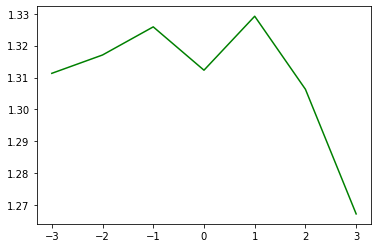

In [59]:
alpha=[1000,100,10,1,0.1,0.01,0.001,0.001]

cv_error=[]

for i in alpha:
    clf=MultinomialNB(alpha=i)
    clf.fit(train_set_ohe,y_train)
    calib=CalibratedClassifierCV(clf,method='sigmoid')
    calib.fit(train_set_ohe,y_train)
    calib_probs = calib.predict_proba(cv_set_ohe)
    cv_error.append(log_loss(y_cv, calib_probs, labels=clf.classes_, eps=1e-15))
    print("Log loss for alpha = {} is {}".format(i,log_loss(y_cv, calib_probs,labels=clf.classes_)))
    
    
plt.plot(np.log10(alpha), cv_error,c='g')
plt.show()

Training log loss is:  1.0472686642472453
CV log loss is:  1.267222084470129
Testing log loss is:  1.401899745640928
Number of missclassified point : 0.4417293233082707


C:\Users\kanis\AppData\Local\Temp\ipykernel_18724\2546487016.py:6: RuntimeWarning: invalid value encountered in divide
  R=(C_M/C_M.sum(axis=0))


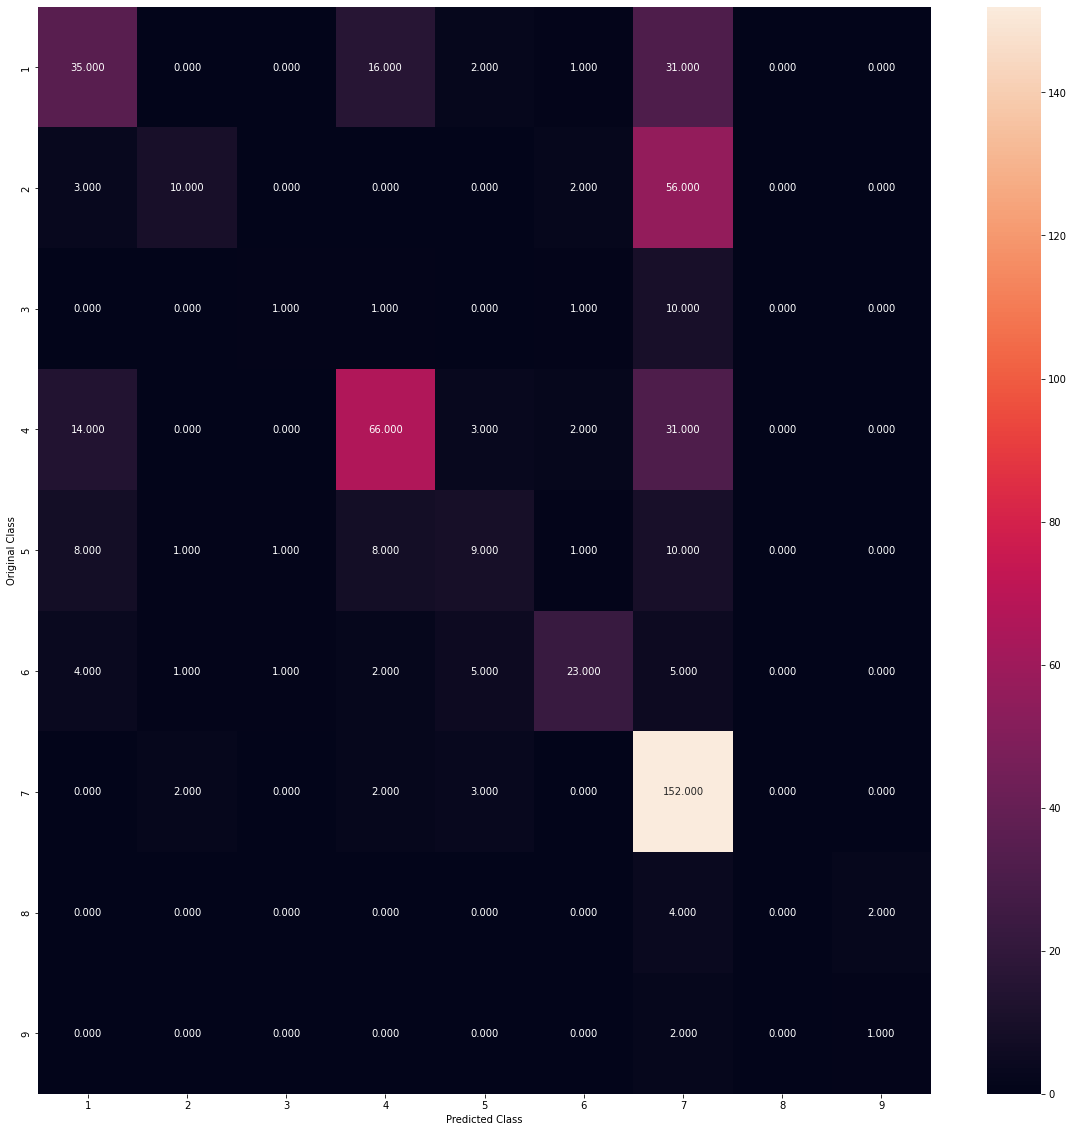

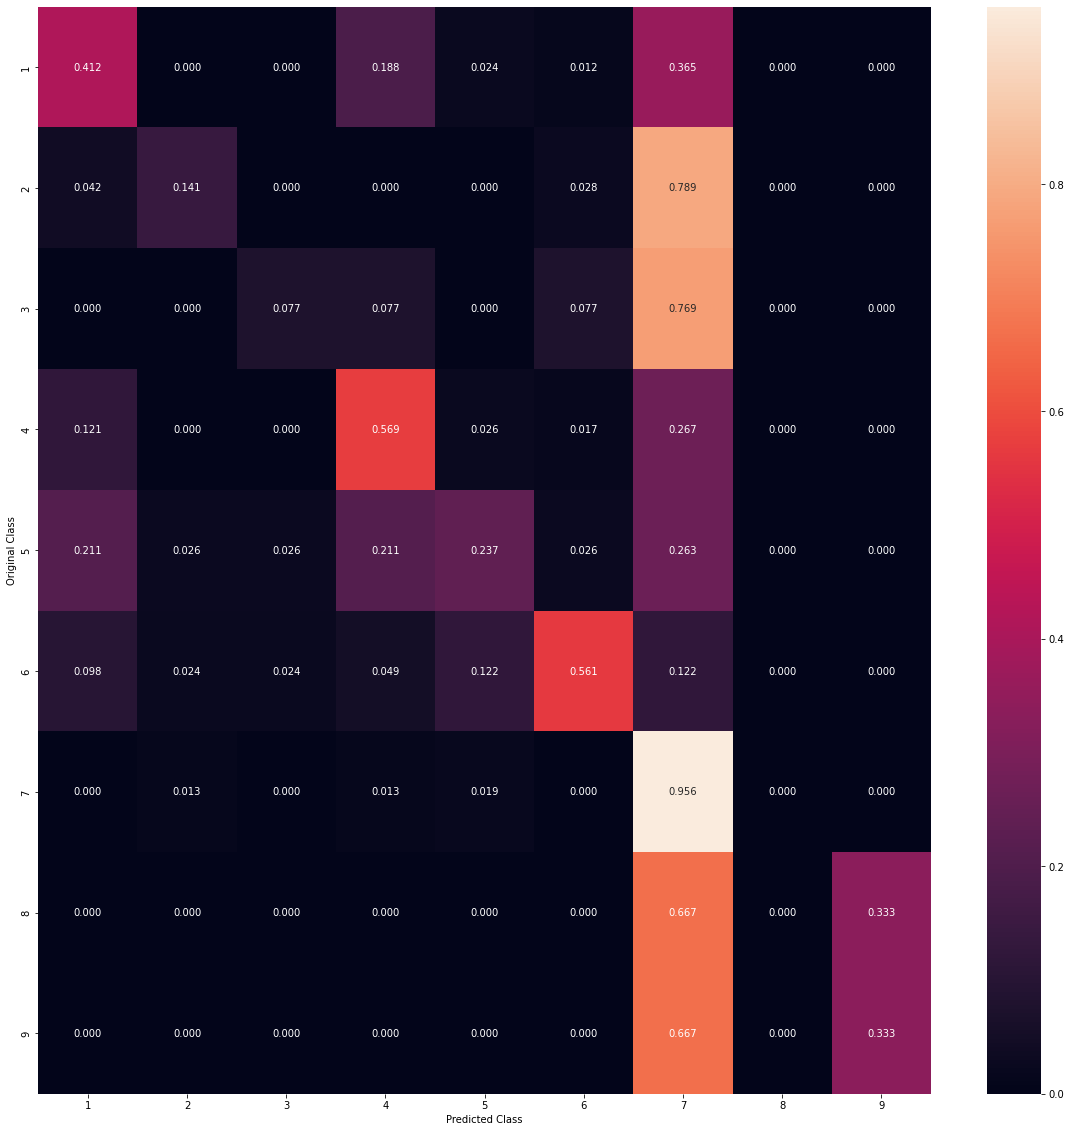

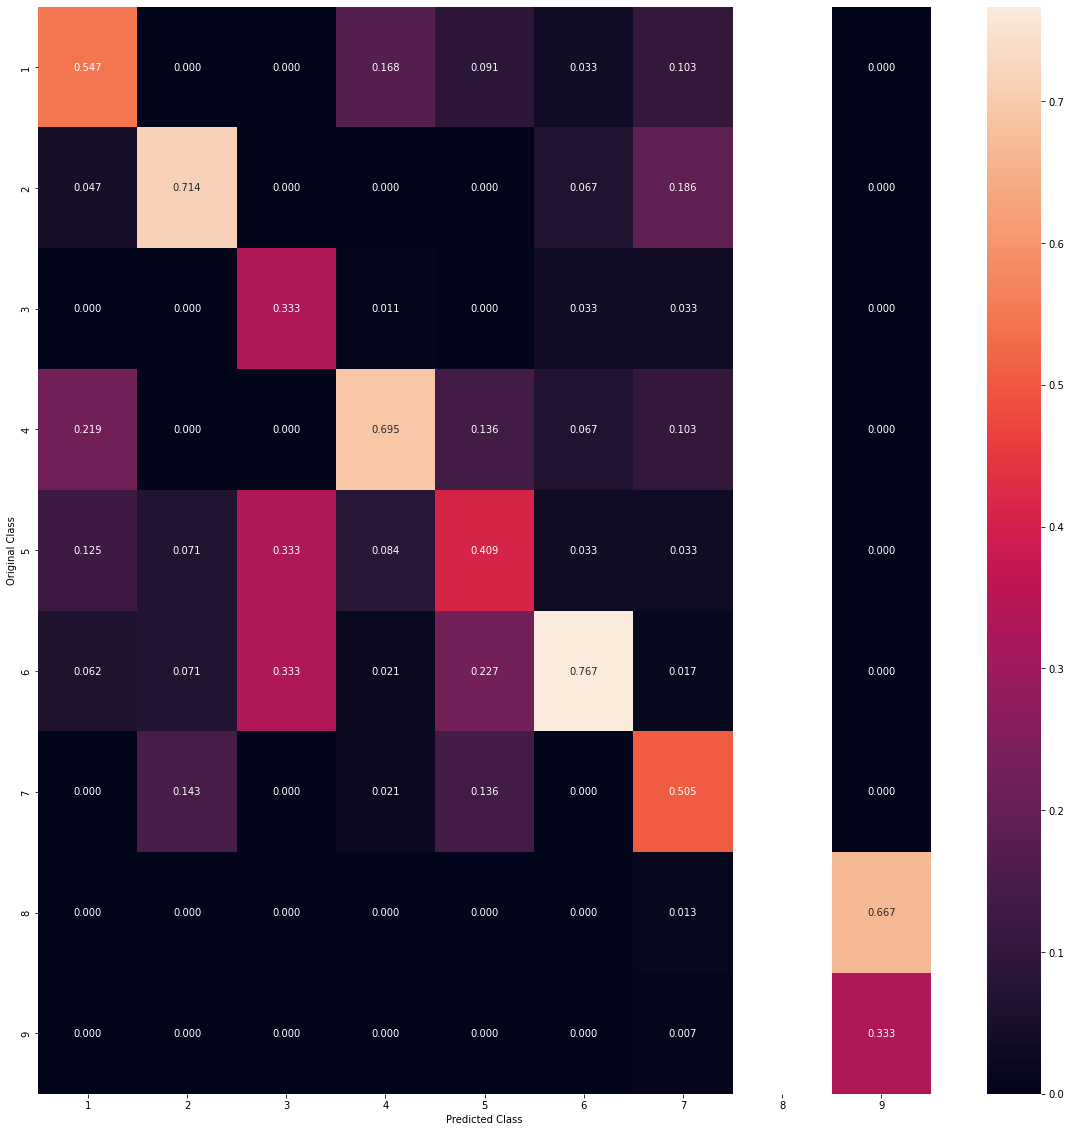

In [60]:
#Training model on best value of alpha & Finding result
best_alpha=np.argmin(cv_error)
clf=MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_set_ohe,y_train)
calib=CalibratedClassifierCV(clf,method='sigmoid')
calib.fit(train_set_ohe,y_train)

calib_probs_train = calib.predict_proba(train_set_ohe)
print("Training log loss is: ",log_loss(y_train, calib_probs_train, labels=clf.classes_, eps=1e-15))
calib_probs_cv = calib.predict_proba(cv_set_ohe)
print("CV log loss is: ",log_loss(y_cv, calib_probs_cv, labels=clf.classes_, eps=1e-15))
calib_probs_test = calib.predict_proba(test_set_ohe)
print("Testing log loss is: ",log_loss(y_test, calib_probs_test, labels=clf.classes_, eps=1e-15))


print("Number of missclassified point :", np.count_nonzero((calib.predict(cv_set_ohe)- y_cv))/y_cv.shape[0])
plot_peformance(y_cv, calib.predict(cv_set_ohe))

# ML Model 2 (KNN)

Log loss for alpha = 5 is 1.3019813822678628
Log loss for alpha = 10 is 1.3064001047721607
Log loss for alpha = 20 is 1.3712254111263178
Log loss for alpha = 35 is 1.4303714362197562
Log loss for alpha = 50 is 1.3984650803255794
Log loss for alpha = 60 is 1.3501390139992369
Log loss for alpha = 70 is 1.3615769096711028
Log loss for alpha = 85 is 1.395425646512803
Log loss for alpha = 100 is 1.369348089672095


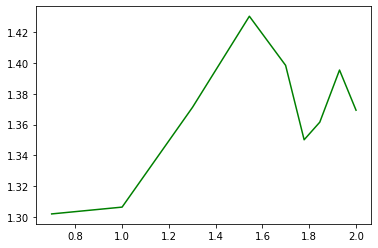

In [61]:
neareat_nighbours=[5,10,20,35,50,60,70,85,100]

cv_error=[]

for i in neareat_nighbours:
    clf=KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_set_ohe,y_train)
    calib=CalibratedClassifierCV(clf,method='sigmoid')
    calib.fit(train_set_ohe,y_train)
    calib_probs = calib.predict_proba(cv_set_ohe)
    cv_error.append(log_loss(y_cv, calib_probs, labels=clf.classes_, eps=1e-15))
    print("Log loss for alpha = {} is {}".format(i,log_loss(y_cv, calib_probs,labels=clf.classes_)))
    
    
plt.plot(np.log10(neareat_nighbours), cv_error,c='g')
plt.show()

Log loss for alpha = 5 is 1.2690557213788585
Log loss for alpha = 11 is 1.2892530504998512
Log loss for alpha = 21 is 1.348252844713188
Log loss for alpha = 35 is 1.411584598204243
Log loss for alpha = 51 is 1.4202747591943818
Log loss for alpha = 61 is 1.4086716098040466
Log loss for alpha = 71 is 1.410475341919671
Log loss for alpha = 85 is 1.4367401964929485
Log loss for alpha = 99 is 1.4344356018777786


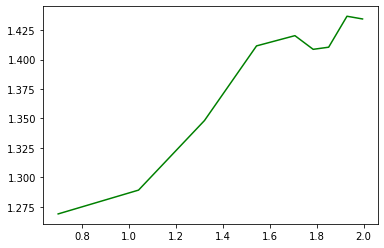

In [62]:
neareat_nighbours=[5,11,21,35,51,61,71,85,99]

cv_error=[]

for i in neareat_nighbours:
    clf=KNeighborsClassifier(n_neighbors=i,weights='distance')
    clf.fit(train_set_ohe,y_train)
    calib=CalibratedClassifierCV(clf,method='sigmoid')
    calib.fit(train_set_ohe,y_train)
    calib_probs = calib.predict_proba(cv_set_ohe)
    cv_error.append(log_loss(y_cv, calib_probs, labels=clf.classes_, eps=1e-15))
    print("Log loss for alpha = {} is {}".format(i,log_loss(y_cv, calib_probs,labels=clf.classes_)))
    
    
plt.plot(np.log10(neareat_nighbours), cv_error,c='g')
plt.show()

Giving train error low but test and cv error high(not considered)

Training log loss is:  0.9457104491584113
CV log loss is:  1.3019813822678628
Testing log loss is:  1.4328140451327012
Number of missclassified point : 0.4548872180451128


C:\Users\kanis\AppData\Local\Temp\ipykernel_18724\2546487016.py:6: RuntimeWarning: invalid value encountered in divide
  R=(C_M/C_M.sum(axis=0))


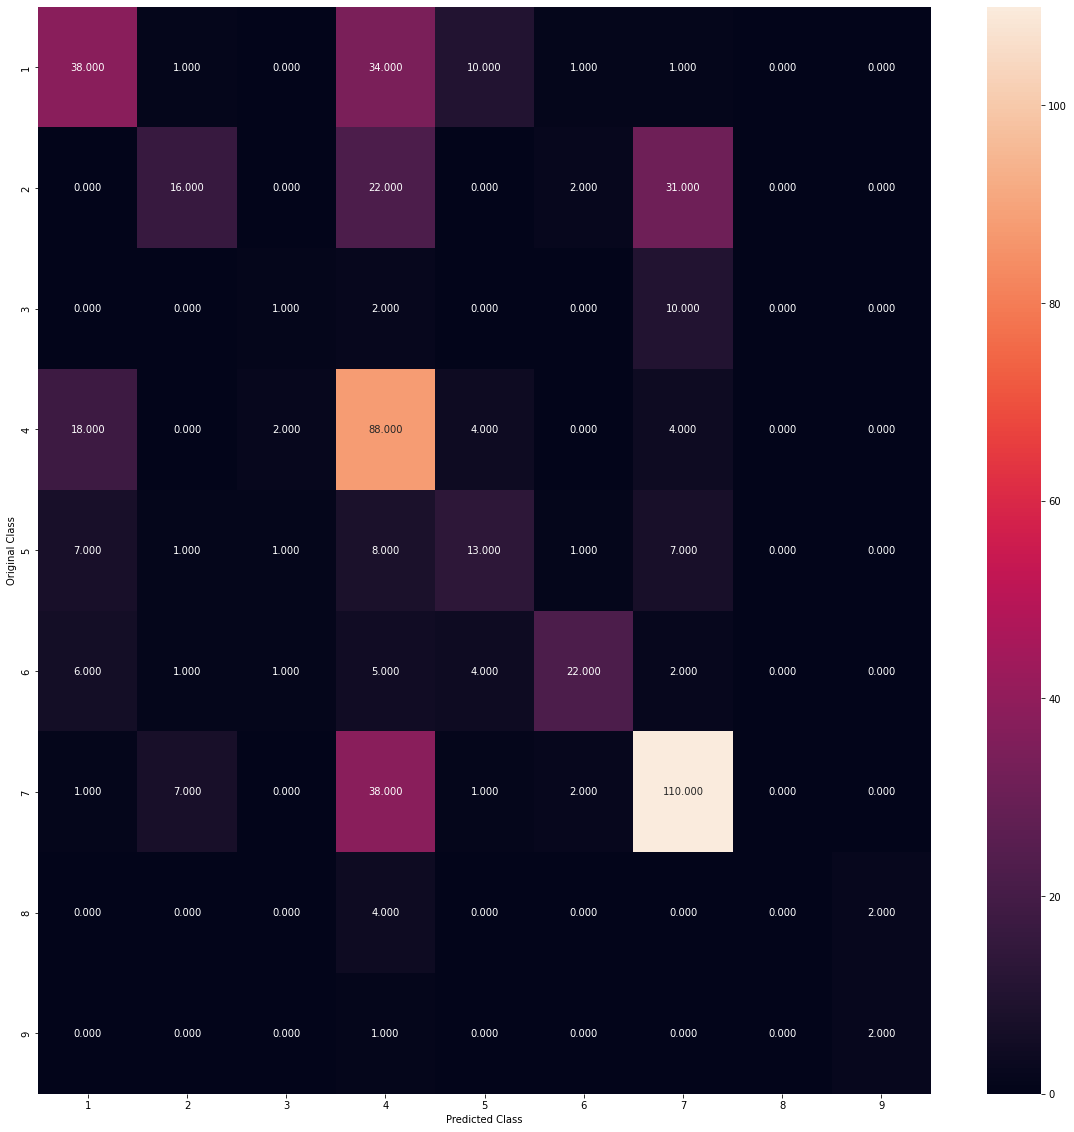

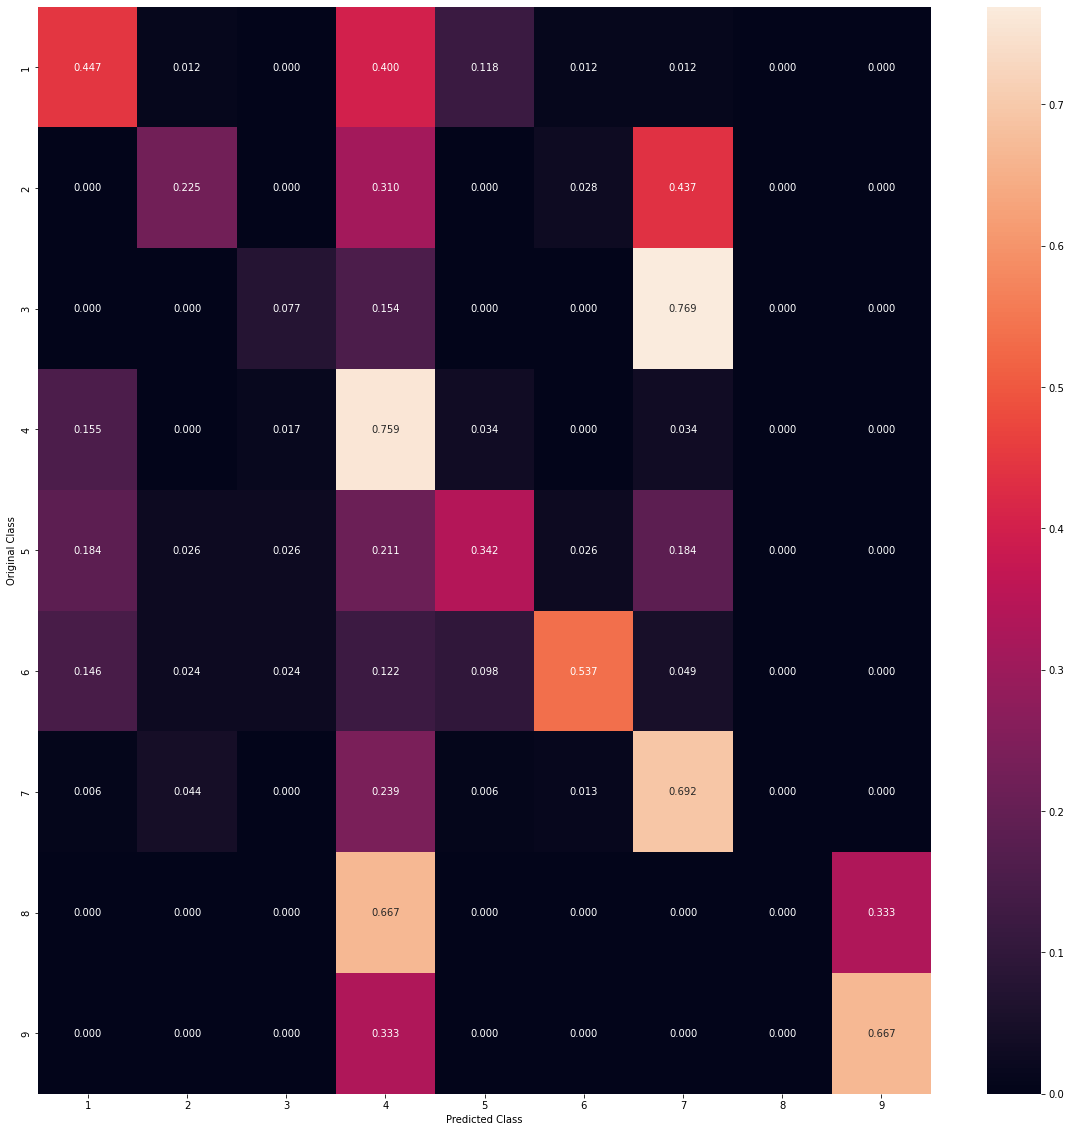

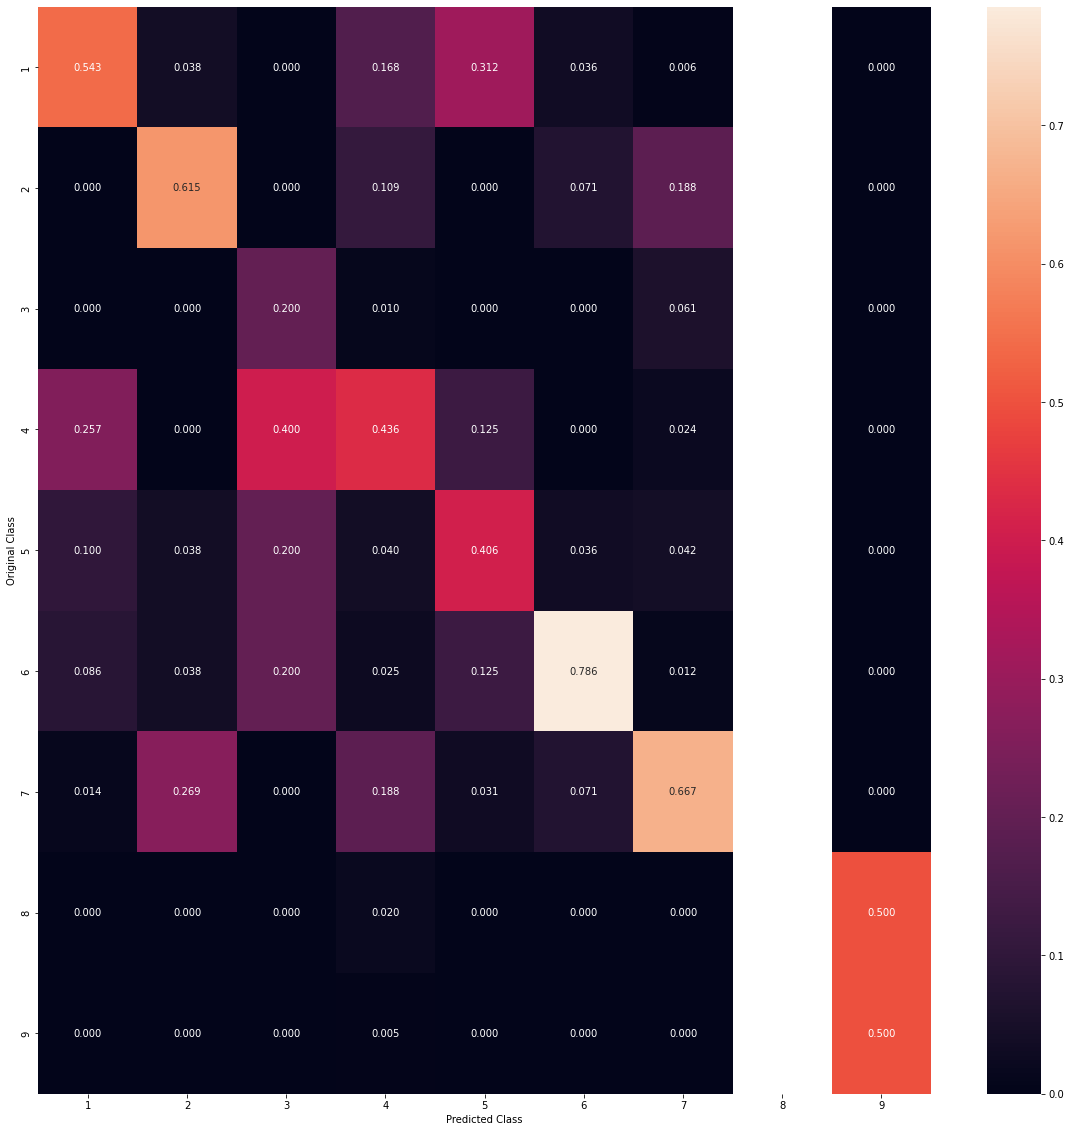

In [63]:
#Training model on best value of Nearest Neighbor & Finding result
best_n=np.argmin(cv_error)
clf=KNeighborsClassifier(n_neighbors=neareat_nighbours[best_n])
clf.fit(train_set_ohe,y_train)
calib=CalibratedClassifierCV(clf,method='sigmoid')
calib.fit(train_set_ohe,y_train)

calib_probs_train = calib.predict_proba(train_set_ohe)
print("Training log loss is: ",log_loss(y_train, calib_probs_train, labels=clf.classes_, eps=1e-15))
calib_probs_cv = calib.predict_proba(cv_set_ohe)
print("CV log loss is: ",log_loss(y_cv, calib_probs_cv, labels=clf.classes_, eps=1e-15))
calib_probs_test = calib.predict_proba(test_set_ohe)
print("Testing log loss is: ",log_loss(y_test, calib_probs_test, labels=clf.classes_, eps=1e-15))


print("Number of missclassified point :", np.count_nonzero((calib.predict(cv_set_ohe)- y_cv))/y_cv.shape[0])
plot_peformance(y_cv, calib.predict(cv_set_ohe))

# ML Models 3(Logistic Regression)

Log loss for alpha and penalty= 1000 and 1.353462447568934 is
Log loss for alpha and penalty= 100 and 1.3522186562548426 is
Log loss for alpha and penalty= 10 and 1.3406506438244448 is
Log loss for alpha and penalty= 1 and 1.2899347546412827 is
Log loss for alpha and penalty= 0.1 and 1.2408089390519192 is
Log loss for alpha and penalty= 0.01 and 1.1793868800851874 is
Log loss for alpha and penalty= 0.001 and 1.1678631072652752 is
Log loss for alpha and penalty= 0.001 and 1.1652853802081609 is
Log loss for alpha and penalty= 0.0001 and 1.3946597574000228 is
Log loss for alpha and penalty= 1e-05 and 1.5428157956780217 is


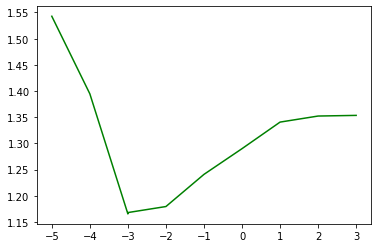

In [73]:
alpha=[1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001]

cv_error=[]

for i in alpha:
    clf=SGDClassifier(alpha=i,penalty='l2',class_weight='balanced',loss='log_loss')
    clf.fit(train_set_ohe,y_train)
    calib=CalibratedClassifierCV(clf,method='sigmoid')
    calib.fit(train_set_ohe,y_train)
    calib_probs = calib.predict_proba(cv_set_ohe)
    cv_error.append(log_loss(y_cv, calib_probs, labels=clf.classes_, eps=1e-15))
    print("Log loss for alpha= {} is {}".format(i,log_loss(y_cv, calib_probs,labels=clf.classes_)))
    
    
plt.plot(np.log10(alpha), cv_error,c='g')
plt.show()

Training log loss is:  0.6315055038304067
CV log loss is:  1.1824651848891692
Testing log loss is:  1.2913543062726989
Number of missclassified point : 0.37030075187969924


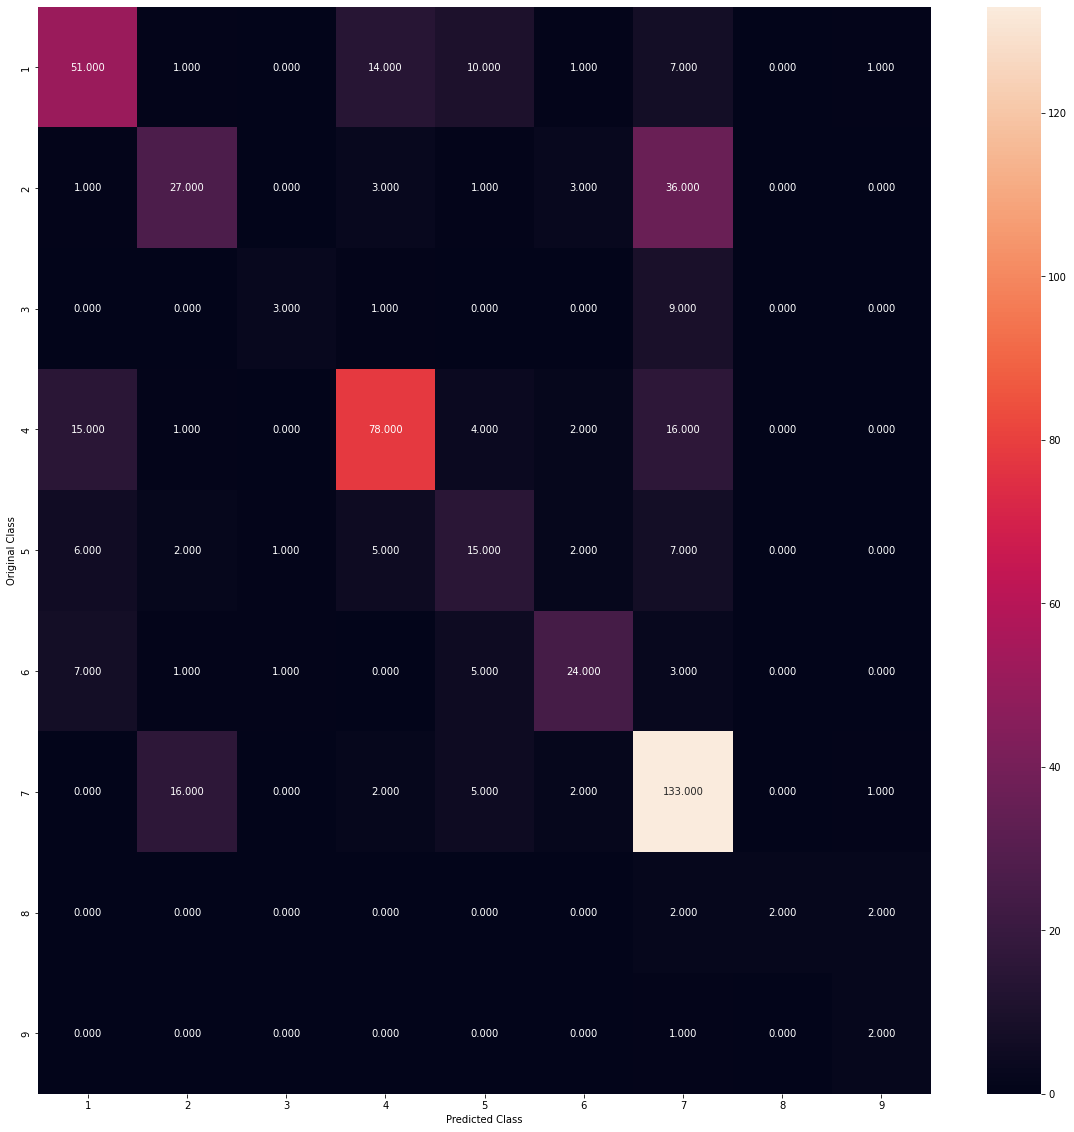

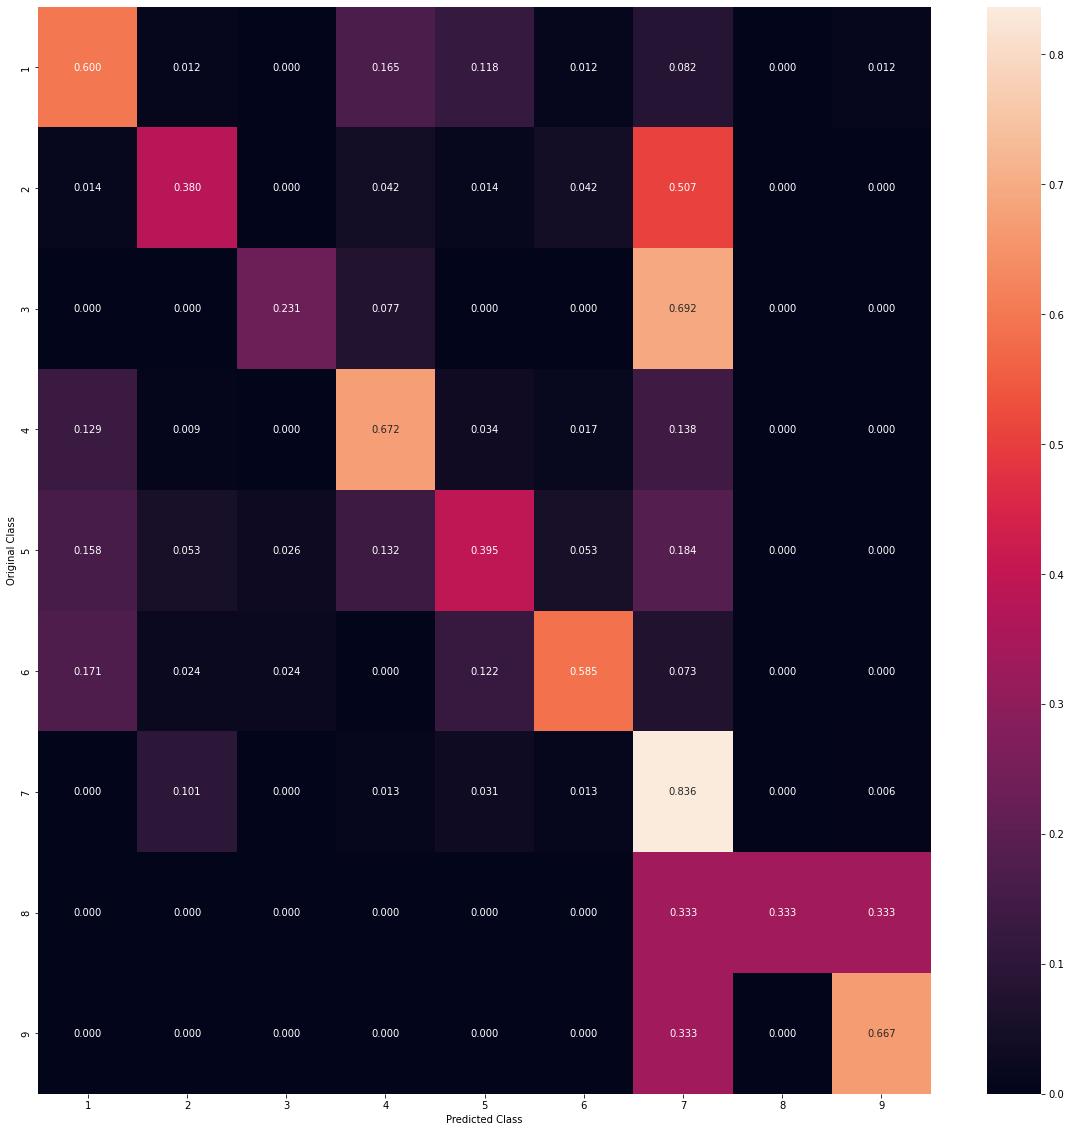

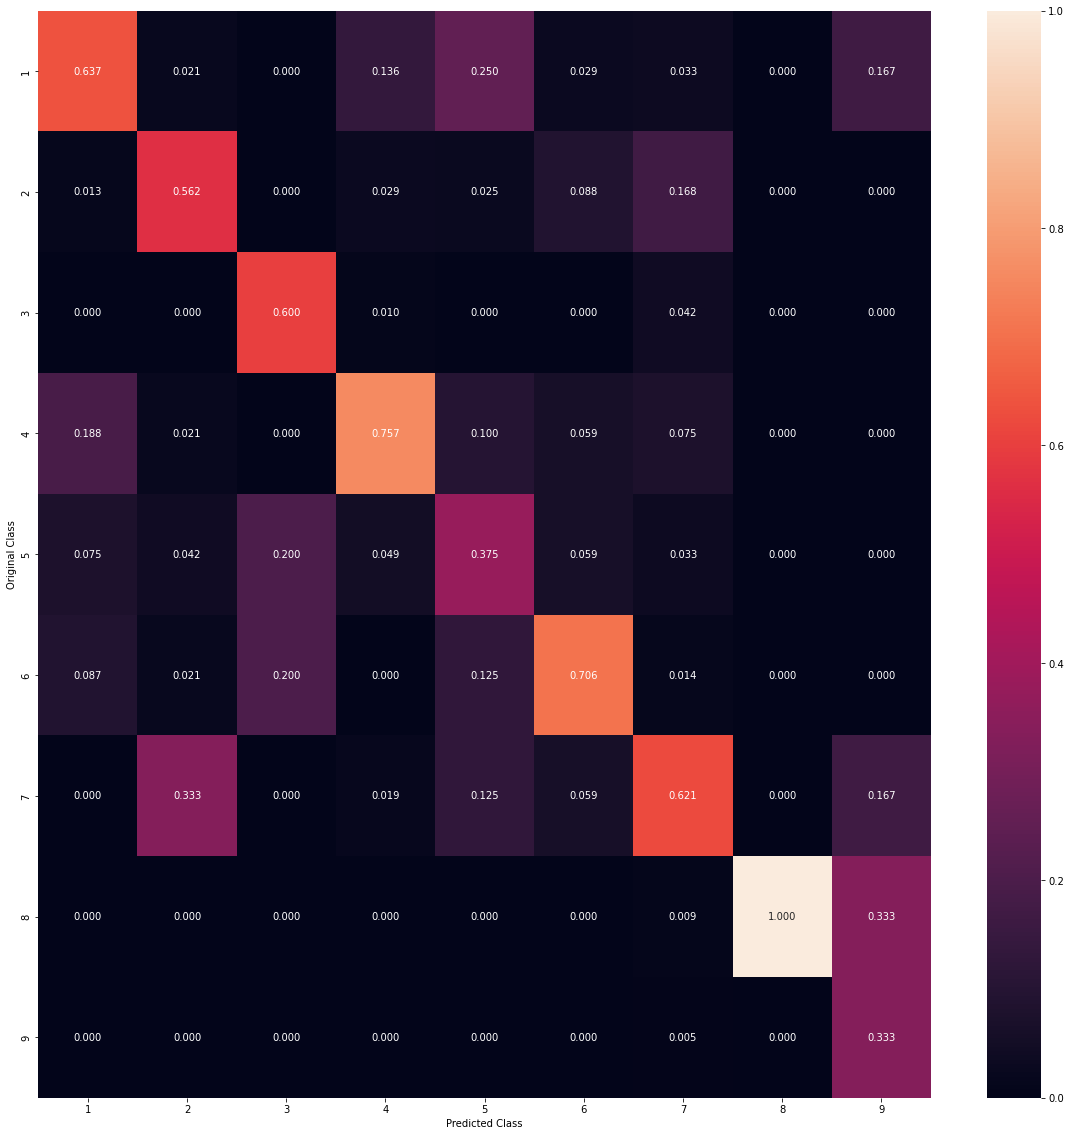

In [76]:
#Training model on best value of Logistic Regression & Finding result
best_alpha=np.argmin(cv_error)
clf=SGDClassifier(alpha=0.01,penalty='l2',class_weight='balanced',loss='log_loss')
clf.fit(train_set_ohe,y_train)
calib=CalibratedClassifierCV(clf,method='sigmoid')
calib.fit(train_set_ohe,y_train)

calib_probs_train = calib.predict_proba(train_set_ohe)
print("Training log loss is: ",log_loss(y_train, calib_probs_train, labels=clf.classes_, eps=1e-15))
calib_probs_cv = calib.predict_proba(cv_set_ohe)
print("CV log loss is: ",log_loss(y_cv, calib_probs_cv, labels=clf.classes_, eps=1e-15))
calib_probs_test = calib.predict_proba(test_set_ohe)
print("Testing log loss is: ",log_loss(y_test, calib_probs_test, labels=clf.classes_, eps=1e-15))


print("Number of missclassified point :", np.count_nonzero((calib.predict(cv_set_ohe)- y_cv))/y_cv.shape[0])
plot_peformance(y_cv, calib.predict(cv_set_ohe))

# ML MODEL 4(Linear SVM)

Log loss for alpha and penalty= 1000 is 1.3536825905869103
Log loss for alpha and penalty= 100 is 1.3536837242825754
Log loss for alpha and penalty= 10 is 1.3518811398327715
Log loss for alpha and penalty= 1 is 1.3303551437982117
Log loss for alpha and penalty= 0.1 is 1.2522370923880235
Log loss for alpha and penalty= 0.01 is 1.204748591045499
Log loss for alpha and penalty= 0.001 is 1.3520798450698361
Log loss for alpha and penalty= 0.0001 is 1.4885305665995856
Log loss for alpha and penalty= 1e-05 is 1.5203756088822666


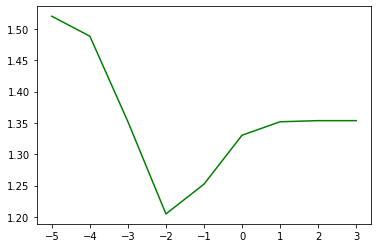

In [78]:
alpha=[1000,100,10,1,0.1,0.01,0.001,0.0001,0.00001]

cv_error=[]

for i in alpha:
    clf=SGDClassifier(alpha=i,penalty='l2',class_weight='balanced',loss='hinge')
    clf.fit(train_set_ohe,y_train)
    calib=CalibratedClassifierCV(clf,method='sigmoid')
    calib.fit(train_set_ohe,y_train)
    calib_probs = calib.predict_proba(cv_set_ohe)
    cv_error.append(log_loss(y_cv, calib_probs, labels=clf.classes_, eps=1e-15))
    print("Log loss for alpha and penalty= {} is {}".format(i,log_loss(y_cv, calib_probs,labels=clf.classes_)))
    
    
plt.plot(np.log10(alpha), cv_error,c='g')
plt.show()

Training log loss is:  0.7220123608452707
CV log loss is:  1.2003519359099235
Testing log loss is:  1.2880279729747968
Number of missclassified point : 0.37030075187969924


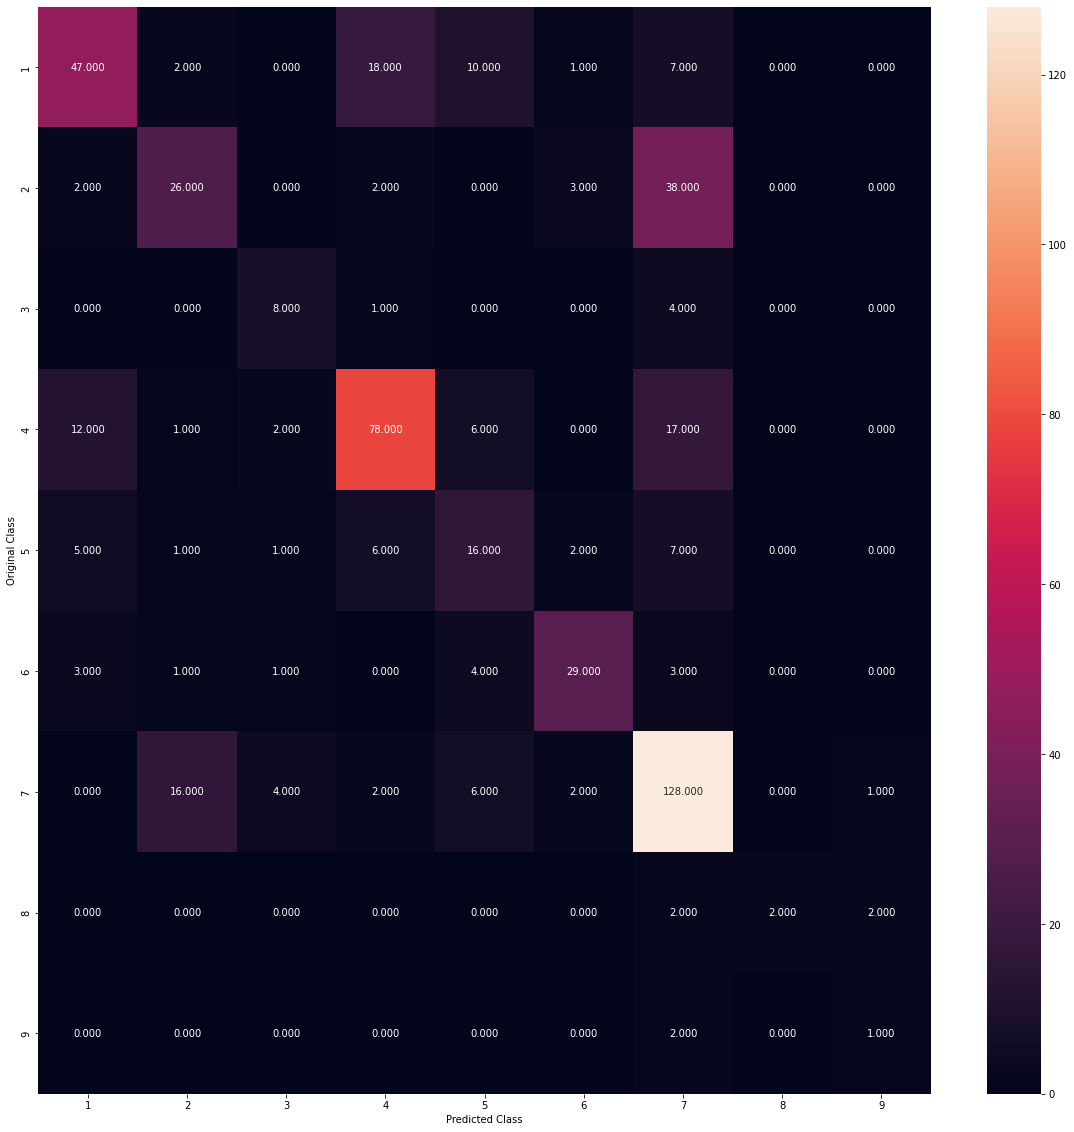

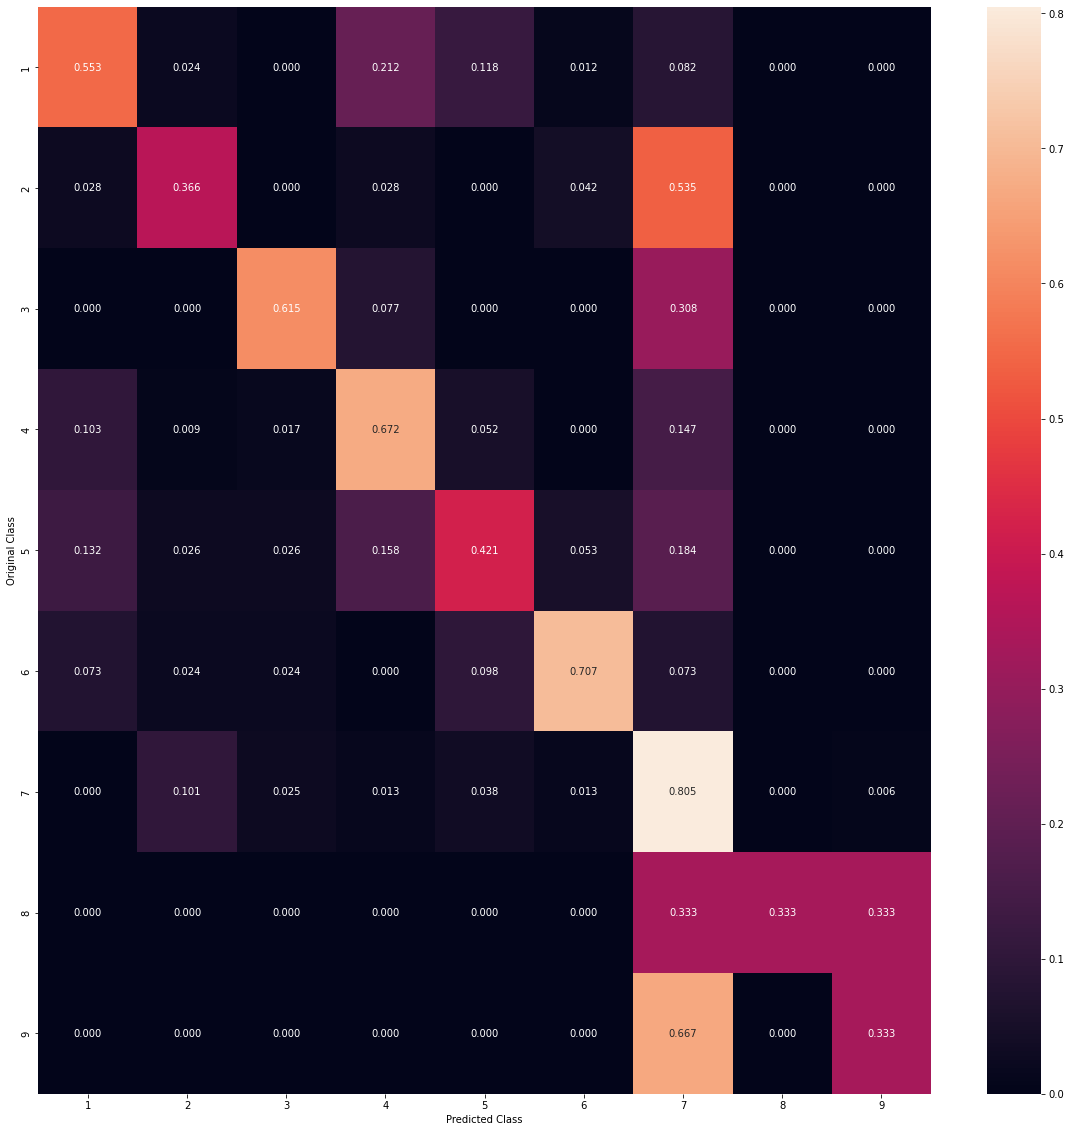

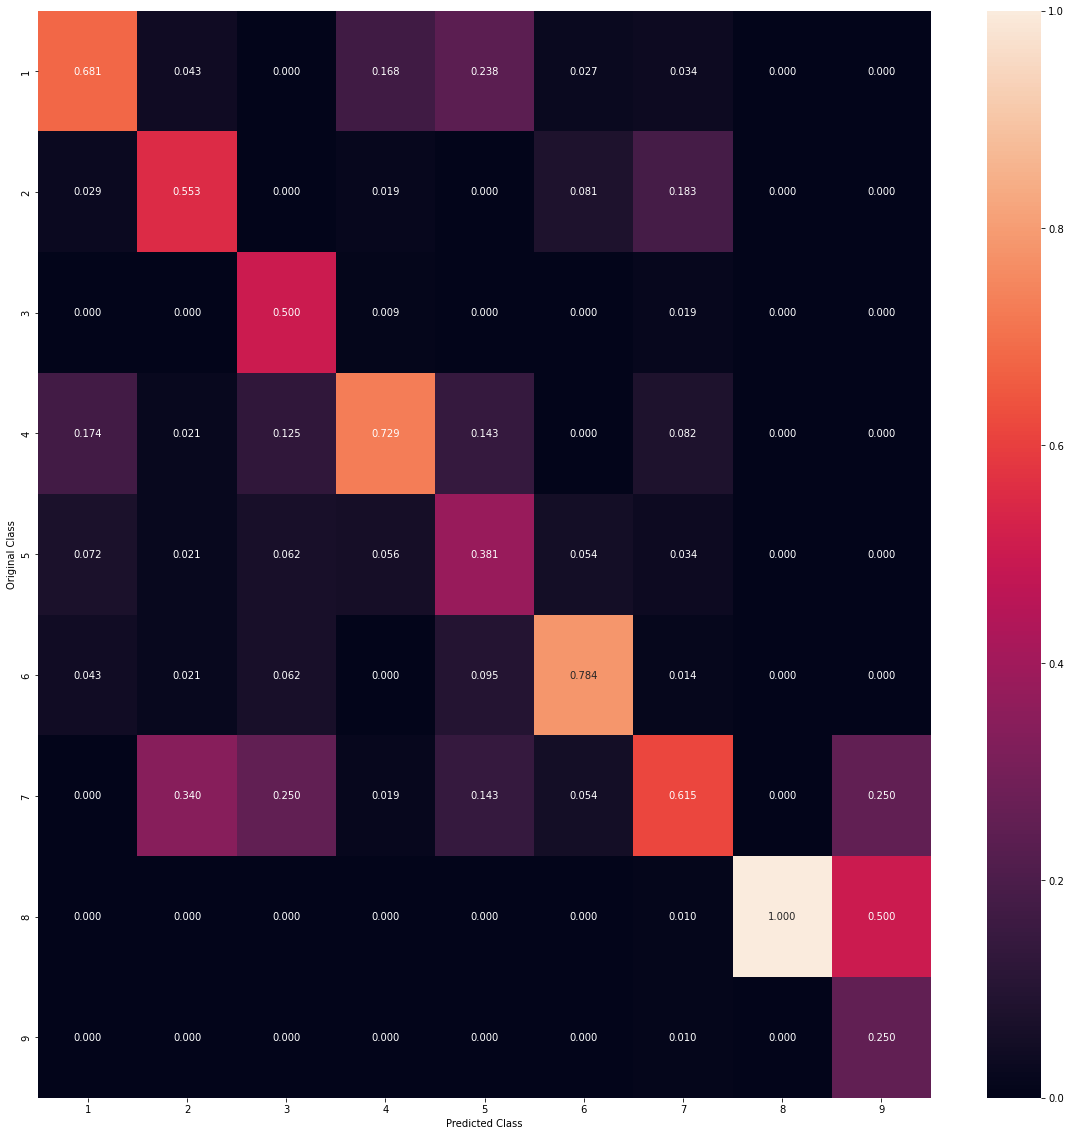

In [79]:
#Training model on best value of Linear SVM & Finding result
best_alpha=np.argmin(cv_error)
clf=SGDClassifier(alpha=0.01,penalty='l2',class_weight='balanced',loss='hinge')
clf.fit(train_set_ohe,y_train)
calib=CalibratedClassifierCV(clf,method='sigmoid')
calib.fit(train_set_ohe,y_train)

calib_probs_train = calib.predict_proba(train_set_ohe)
print("Training log loss is: ",log_loss(y_train, calib_probs_train, labels=clf.classes_, eps=1e-15))
calib_probs_cv = calib.predict_proba(cv_set_ohe)
print("CV log loss is: ",log_loss(y_cv, calib_probs_cv, labels=clf.classes_, eps=1e-15))
calib_probs_test = calib.predict_proba(test_set_ohe)
print("Testing log loss is: ",log_loss(y_test, calib_probs_test, labels=clf.classes_, eps=1e-15))


print("Number of missclassified point :", np.count_nonzero((calib.predict(cv_set_ohe)- y_cv))/y_cv.shape[0])
plot_peformance(y_cv, calib.predict(cv_set_ohe))

# ML Model 5(Random Forest)

In [84]:
n_estimators=[50,75,100,125]
max_depth=[3,5,7,10]
cv_error=[]

for i in n_estimators:
    for j in max_depth:
        clf=RandomForestClassifier(n_estimators=i,max_depth=j)
        clf.fit(train_set_ohe,y_train)
        calib=CalibratedClassifierCV(clf,method='sigmoid')
        calib.fit(train_set_ohe,y_train)
        calib_probs = calib.predict_proba(cv_set_ohe)
        cv_error.append(log_loss(y_cv, calib_probs, labels=clf.classes_, eps=1e-15))
        print("Log loss for n_estimators {} and  depth {} is {}".format(i,j,log_loss(y_cv, calib_probs,labels=clf.classes_)))
    


Log loss for n_estimators 50 and  depth 3 is 1.3591809985691
Log loss for n_estimators 50 and  depth 5 is 1.3042591486849768
Log loss for n_estimators 50 and  depth 7 is 1.230700580825383
Log loss for n_estimators 50 and  depth 10 is 1.1713974387455053
Log loss for n_estimators 75 and  depth 3 is 1.3407994571288964
Log loss for n_estimators 75 and  depth 5 is 1.2839766492914644
Log loss for n_estimators 75 and  depth 7 is 1.2284378504798121
Log loss for n_estimators 75 and  depth 10 is 1.184453189972587
Log loss for n_estimators 100 and  depth 3 is 1.3442317865524696
Log loss for n_estimators 100 and  depth 5 is 1.274458721132825
Log loss for n_estimators 100 and  depth 7 is 1.2313252364916398
Log loss for n_estimators 100 and  depth 10 is 1.1767577690900264
Log loss for n_estimators 125 and  depth 3 is 1.3305635300549299
Log loss for n_estimators 125 and  depth 5 is 1.2617125346993383
Log loss for n_estimators 125 and  depth 7 is 1.2335587945871882
Log loss for n_estimators 125 and  d

Training log loss is:  0.8396756336377588
CV log loss is:  1.171608228141727
Testing log loss is:  1.3078912286076858
Number of missclassified point : 0.34398496240601506


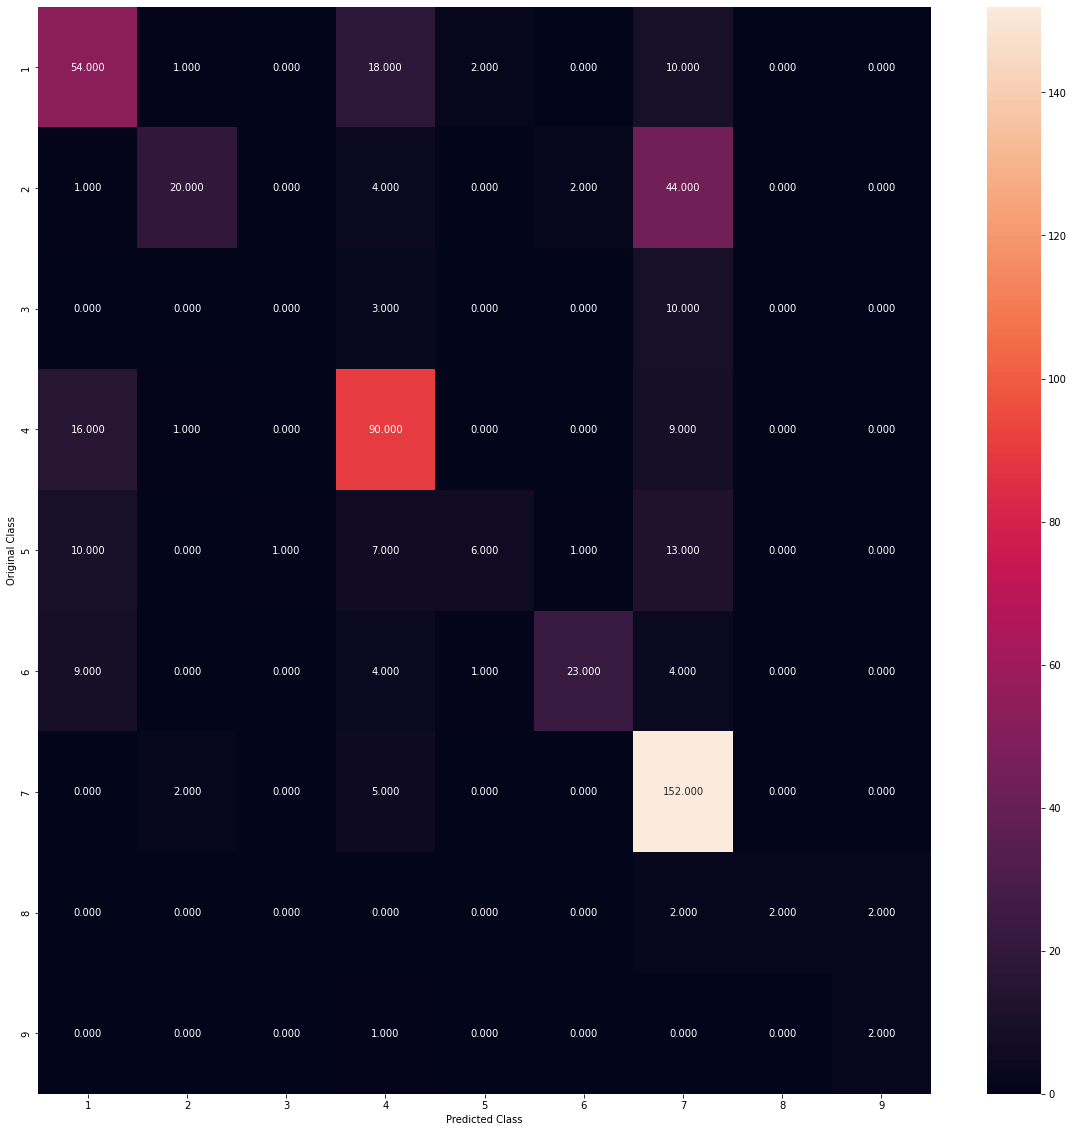

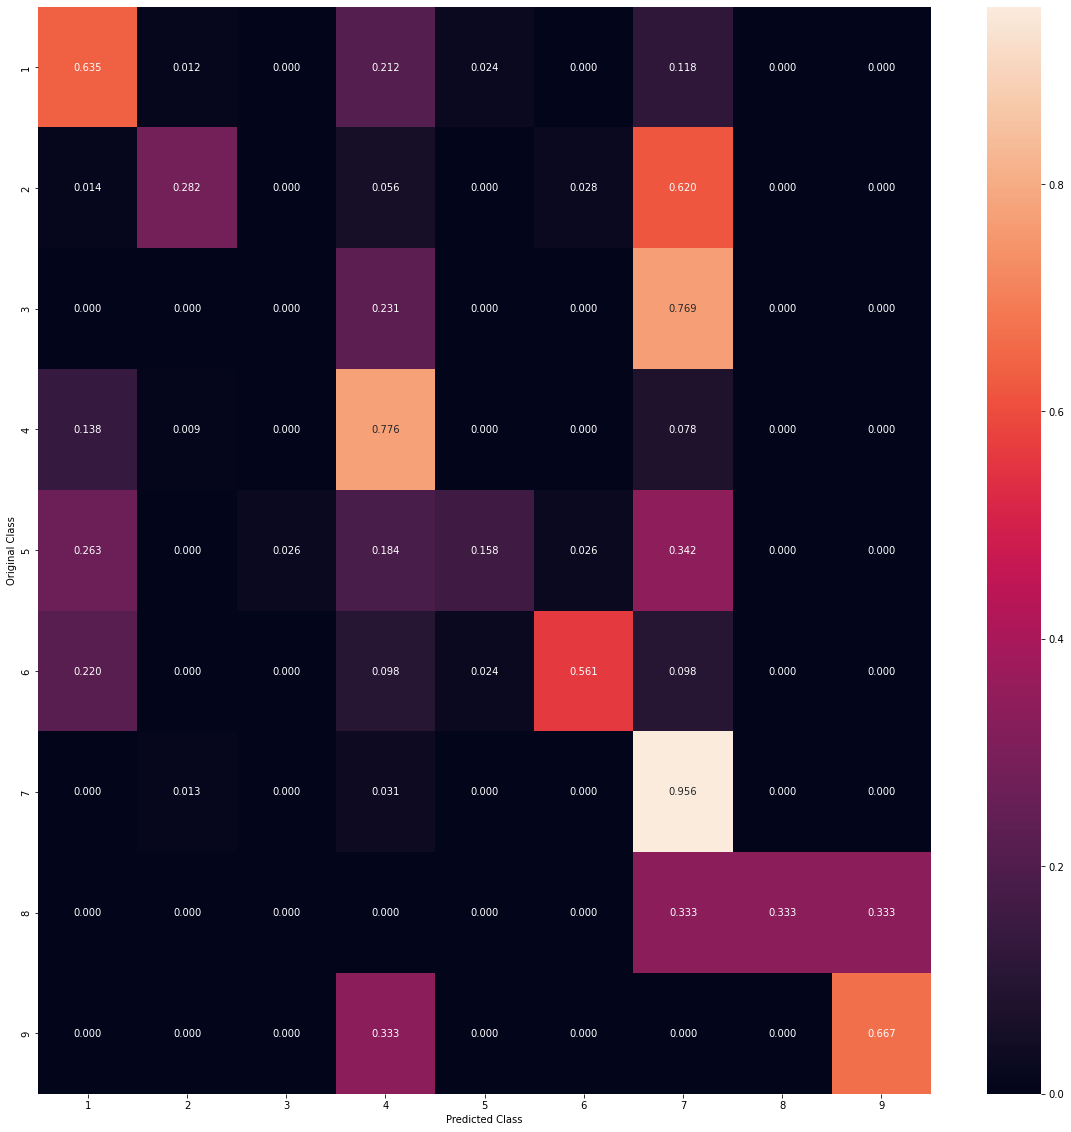

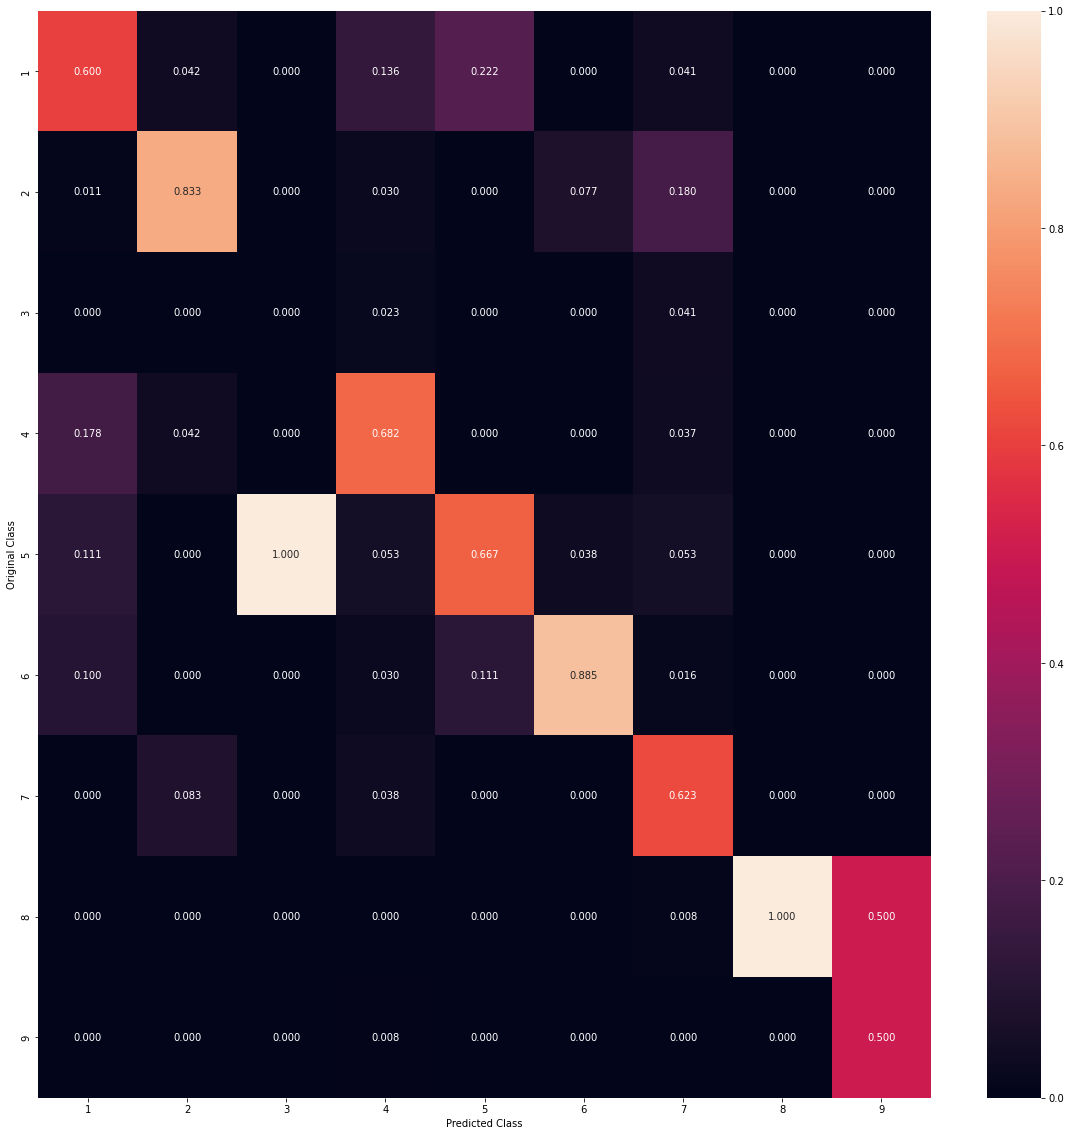

In [85]:
#Training model on best value of Random Forest & Finding result
clf=RandomForestClassifier(n_estimators=125,max_depth=10)
clf.fit(train_set_ohe,y_train)
calib=CalibratedClassifierCV(clf,method='sigmoid')
calib.fit(train_set_ohe,y_train)

calib_probs_train = calib.predict_proba(train_set_ohe)
print("Training log loss is: ",log_loss(y_train, calib_probs_train, labels=clf.classes_, eps=1e-15))
calib_probs_cv = calib.predict_proba(cv_set_ohe)
print("CV log loss is: ",log_loss(y_cv, calib_probs_cv, labels=clf.classes_, eps=1e-15))
calib_probs_test = calib.predict_proba(test_set_ohe)
print("Testing log loss is: ",log_loss(y_test, calib_probs_test, labels=clf.classes_, eps=1e-15))


print("Number of missclassified point :", np.count_nonzero((calib.predict(cv_set_ohe)- y_cv))/y_cv.shape[0])
plot_peformance(y_cv, calib.predict(cv_set_ohe))

In [87]:
n_estimators=[50,75,100,120]
max_depth=[3,5,7,10]
cv_error=[]

for i in n_estimators:
    for j in max_depth:
        clf=RandomForestClassifier(n_estimators=i,max_depth=j)
        clf.fit(train_set_rc,y_train)
        calib=CalibratedClassifierCV(clf,method='sigmoid')
        calib.fit(train_set_rc,y_train)
        calib_probs = calib.predict_proba(cv_set_rc)
        cv_error.append(log_loss(y_cv, calib_probs, labels=clf.classes_, eps=1e-15))
        print("Log loss for n_estimators {} and  depth {} is {}".format(i,j,log_loss(y_cv, calib_probs,labels=clf.classes_)))

Log loss for n_estimators 50 and  depth 3 is 1.4404049228304103
Log loss for n_estimators 50 and  depth 5 is 1.3415813103344458
Log loss for n_estimators 50 and  depth 7 is 1.4695844926670623
Log loss for n_estimators 50 and  depth 10 is 1.6551553110906265
Log loss for n_estimators 75 and  depth 3 is 1.49104623420299
Log loss for n_estimators 75 and  depth 5 is 1.536799932176623
Log loss for n_estimators 75 and  depth 7 is 1.4869060168752806
Log loss for n_estimators 75 and  depth 10 is 1.732547798415605
Log loss for n_estimators 100 and  depth 3 is 1.5062726019728374
Log loss for n_estimators 100 and  depth 5 is 1.3680722736495916
Log loss for n_estimators 100 and  depth 7 is 1.4225890719346308
Log loss for n_estimators 100 and  depth 10 is 1.7244692146486857
Log loss for n_estimators 120 and  depth 3 is 1.4640409101411926
Log loss for n_estimators 120 and  depth 5 is 1.4383769123534587
Log loss for n_estimators 120 and  depth 7 is 1.4766142610158677
Log loss for n_estimators 120 and 

# Ml Model 6(Stacking Classifier)

In [93]:
clf_rf=RandomForestClassifier(n_estimators=125,max_depth=10)
clf_rf.fit(train_set_ohe,y_train)
calib_rf=CalibratedClassifierCV(clf,method='sigmoid')
calib_rf.fit(train_set_ohe,y_train)

clf_svm=SGDClassifier(alpha=0.01,penalty='l2',class_weight='balanced',loss='hinge')
clf_svm.fit(train_set_ohe,y_train)
calib_svm=CalibratedClassifierCV(clf,method='sigmoid')
calib_svm.fit(train_set_ohe,y_train)

clf_lr=SGDClassifier(alpha=0.01,penalty='l2',class_weight='balanced',loss='log_loss')
clf_lr.fit(train_set_ohe,y_train)
calib_lr=CalibratedClassifierCV(clf,method='sigmoid')
calib_lr.fit(train_set_ohe,y_train)

clf_nb=MultinomialNB(alpha=0.001)
clf_nb.fit(train_set_ohe,y_train)
calib_nb=CalibratedClassifierCV(clf,method='sigmoid')
calib_nb.fit(train_set_ohe,y_train)




CalibratedClassifierCV(base_estimator=AdaBoostClassifier(learning_rate=0.8))

In [94]:
alpha=[0.0001,0.001,0.01,0.1,1,10]

for i in alpha:
    log_reg=LogisticRegression(C=i)
    stclf=StackingClassifier(classifiers=[calib_nb,calib_lr,calib_svm,calib_rf],meta_classifier=log_reg,use_probas=True)
    stclf.fit(train_set_ohe,y_train)
    print("Log loss for alpha {} is {}".format(i,log_loss(y_cv, stclf.predict_proba(cv_set_ohe))))

Log loss for alpha 0.0001 is 1.8202704550718267
Log loss for alpha 0.001 is 1.8200074912152697
Log loss for alpha 0.01 is 1.8175936332475082
Log loss for alpha 0.1 is 1.797463447274909


C:\Users\kanis\anaconda3\envs\cancer_dataset\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Log loss for alpha 1 is 1.7486412523377852


C:\Users\kanis\anaconda3\envs\cancer_dataset\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Log loss for alpha 10 is 1.697726106858344


RandomForest is the best model for thid